# Chromosome ideograms

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import geneinfo as gi
gi.email('your@email.com')

Bbox(x0=50000000.0, y0=2.299999999999997, x1=55969788.76009743, y1=4.042857509538209)


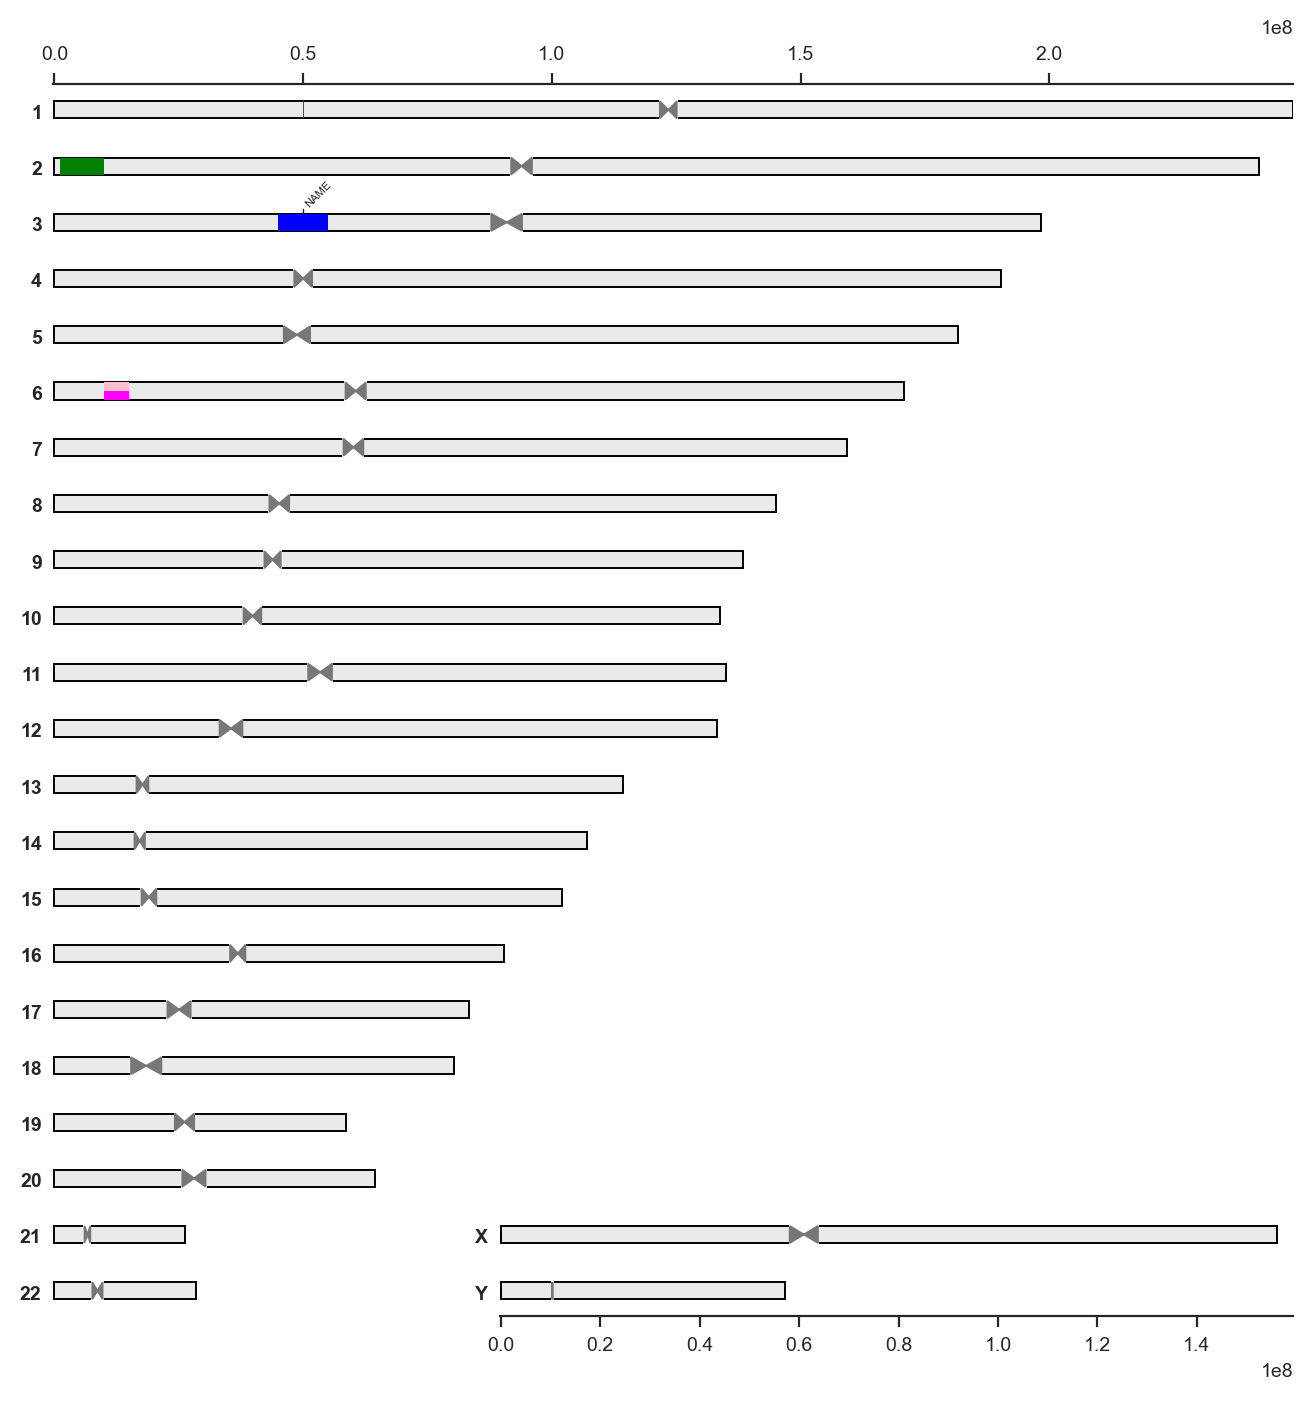

In [2]:
annotation = [
    ('chr1', 50000000, 50001000),                          # segment color defaults to red
    ('chr2', 10000000, 1000000, 'green'),                  # with segment color
    ('chr3', 45000000, 55000000, 'blue', 'NAME'),          # with name label
    ('chr6', 10000000, 15000000, 'magenta', None, 0, 0.5), # with base and height
    ('chr6', 10000000, 15000000, 'pink', None, 0.5, 0.5),  # with base and height
]

gi.chrom_ideogram(annotation, figsize=(8, 8))

To make sure segments are visible on the plot, the default minimal size of plotteed segments are 200000. This can be changed like this (notice how the chr1 segment is no longer visible):

Bbox(x0=50000000.0, y0=2.299999999999997, x1=55969788.76009743, y1=3.8909902576697277)


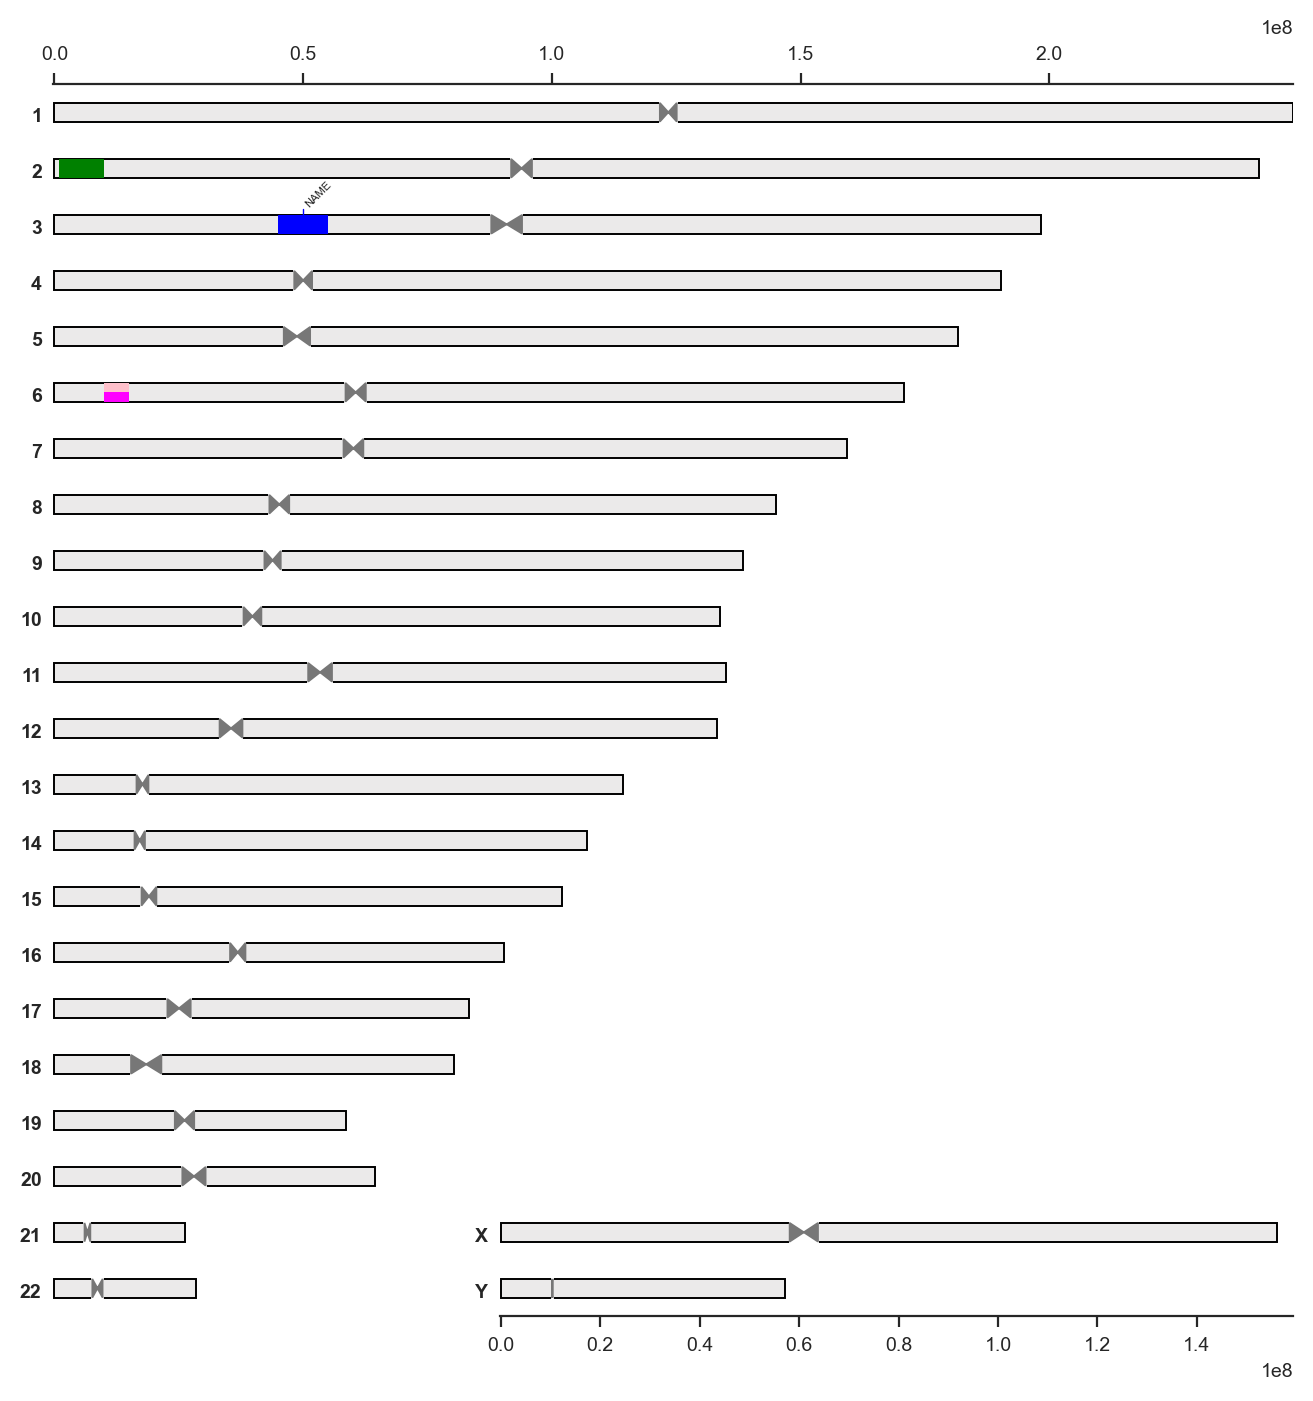

In [3]:
gi.chrom_ideogram(annotation, figsize=(8, 8), min_visible_width=1, hspace=0)

Other assembly, figure dimentions:

Bbox(x0=49999999.99999999, y0=2.299999999999997, x1=55976834.941172086, y1=4.042857509538209)


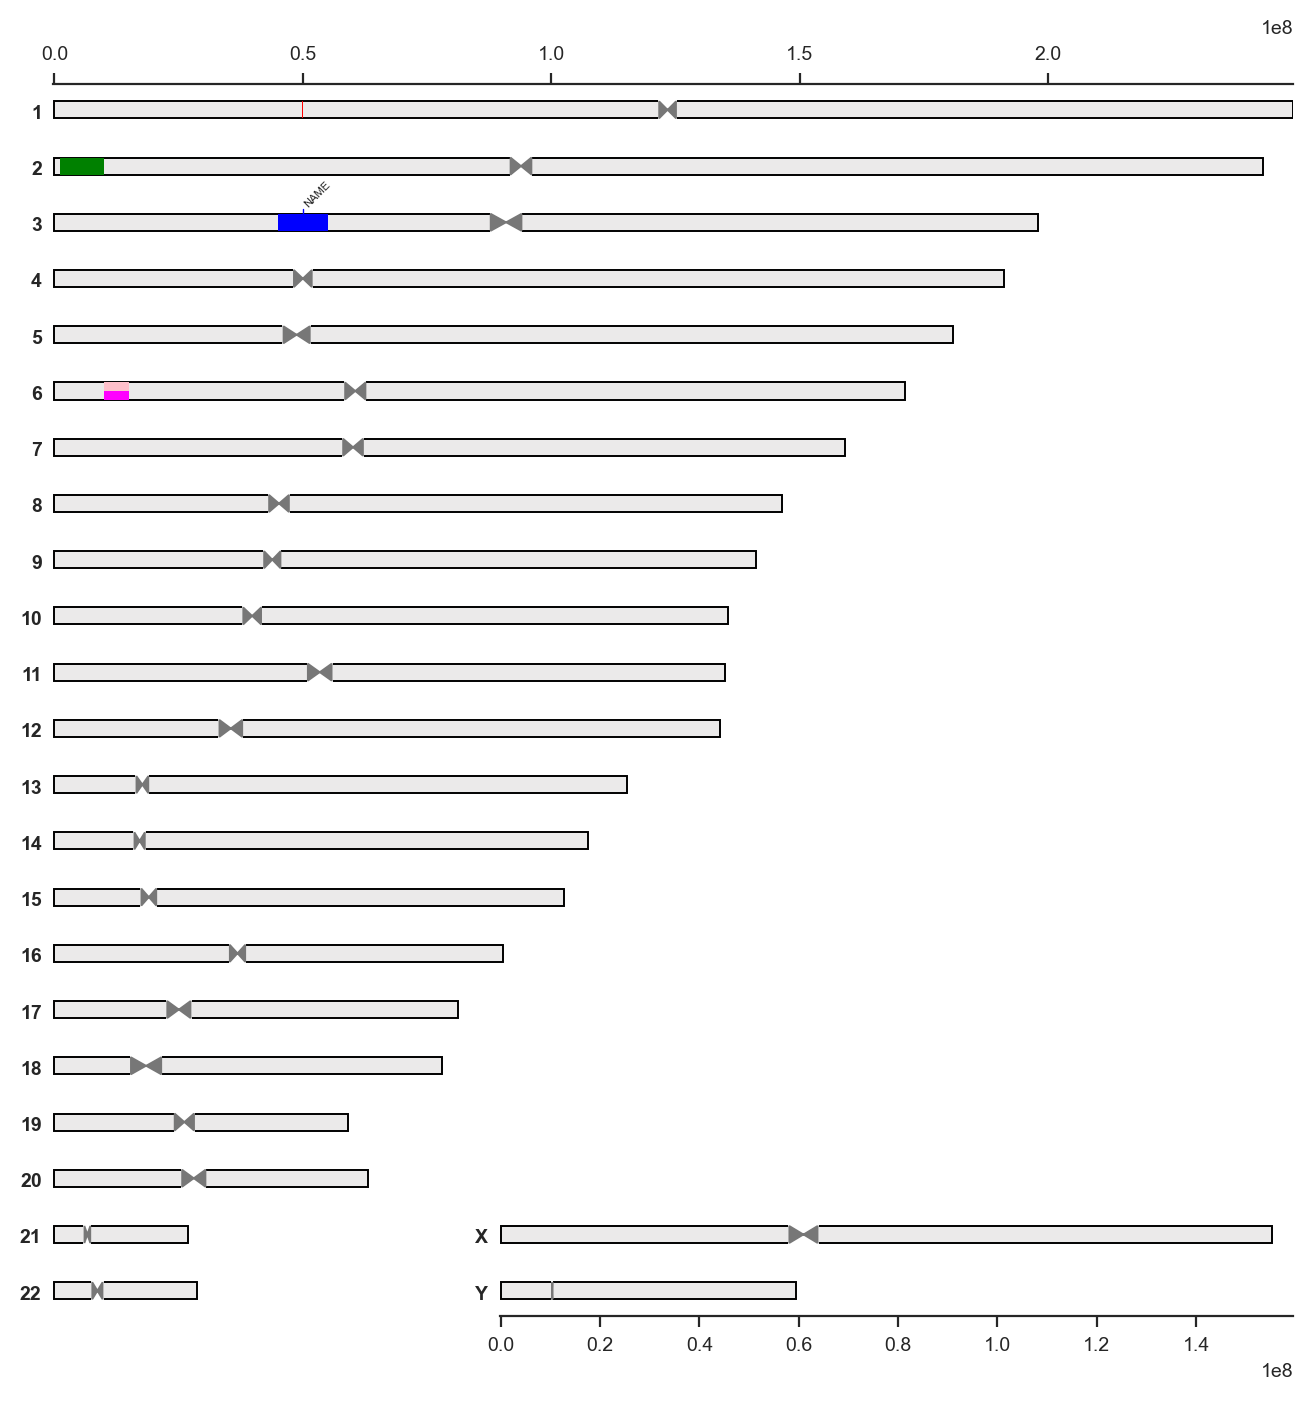

In [4]:
gi.chrom_ideogram(annotation, assembly='hg19', figsize=(8, 8))

**You can add position markers along a chromosome like this to better see the location of some segments:**

Bbox(x0=50000000.0, y0=2.299999999999997, x1=55969788.76009743, y1=4.042857509538209)
Bbox(x0=100000000.5, y0=2.299999999999997, x1=104512876.5269784, y1=3.6175172839961505)
Bbox(x0=110000000.5, y0=2.299999999999997, x1=114406273.15626237, y1=3.586394828468684)
Bbox(x0=120000000.5, y0=2.299999999999997, x1=124512876.5269784, y1=3.6175172839961505)
Bbox(x0=130000000.5, y0=2.299999999999997, x1=134512876.5269784, y1=3.6175172839961505)
Bbox(x0=140000000.5, y0=2.299999999999997, x1=144512876.5269784, y1=3.6175172839961505)
Bbox(x0=150000000.5, y0=2.299999999999997, x1=154512876.52697843, y1=3.6175172839961505)
Bbox(x0=160000000.5, y0=2.299999999999997, x1=164512876.52697843, y1=3.6175172839961505)
Bbox(x0=170000000.5, y0=2.299999999999997, x1=174512876.5269784, y1=3.6175172839961505)
Bbox(x0=180000000.5, y0=2.299999999999997, x1=184512876.5269784, y1=3.6175172839961505)
Bbox(x0=190000000.5, y0=2.299999999999997, x1=194512876.5269784, y1=3.6175172839961505)


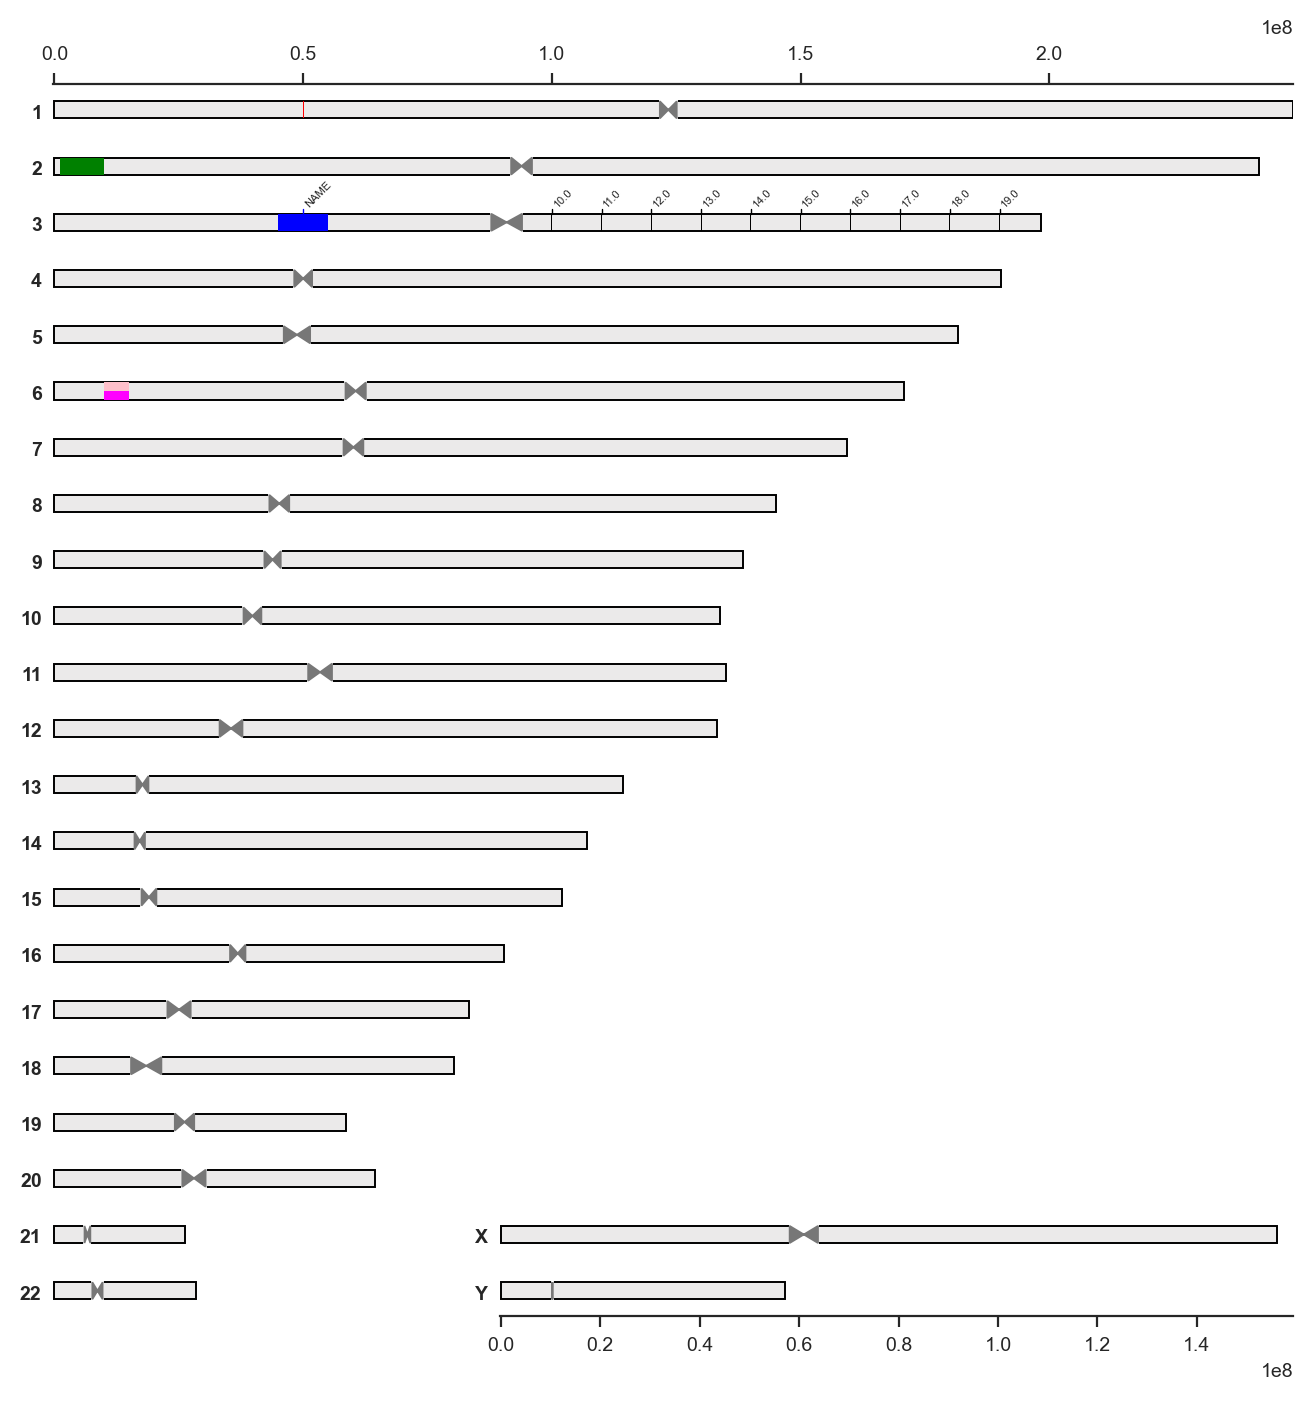

In [5]:
chrom = 'chr3'
start = 100000000
end = 200000000
width = 10000000
annotation2 = annotation + [(chrom, x[0], x[1], 'black', str(x[2]/width)) for x in zip(
    range(start, end, width), 
    range(start+1, end, width), 
    range(start, end, width)
)]
gi.chrom_ideogram(annotation2, figsize=(8, 8))

In [6]:
lists = gi.GoogleSheet()

In [7]:
import importlib
import geneinfo
importlib.reload(geneinfo)

coords = gi.gene_coord(lists.get('xi_escape'), assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [8]:
coords = gi.gene_coord(['ATRX', 'MAGT1'], assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [9]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        self.points = points

    def get_points(self):
        return self.points

    def nudge_y(self, nudge):
        for point in self.points:
            point.y += nudge

def is_polygons_intersecting(a, b):
    for x in range(2):
        polygon = a if x == 0 else b

        for i1 in range(len(polygon.get_points())):
            i2 = (i1 + 1) % len(polygon.get_points())
            p1 = polygon.get_points()[i1]
            p2 = polygon.get_points()[i2]

            normal = Point(p2.y - p1.y, p1.x - p2.x)

            min_a = float('inf')
            max_a = float('-inf')

            for p in a.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_a = min(min_a, projected)
                max_a = max(max_a, projected)

            min_b = float('inf')
            max_b = float('-inf')

            for p in b.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_b = min(min_b, projected)
                max_b = max(max_b, projected)

            if max_a < min_b or max_b < min_a:
                return False

    return True

a = list(zip([0, 0, 2, 2], [0, 2, 2, 0]))
b = list(zip([1, 1, 3, 3], [1, 3, 3, 1]))

is_polygons_intersecting(
    Polygon([Point(*tup) for tup in a]),
    Polygon([Point(*tup) for tup in b])
)

True

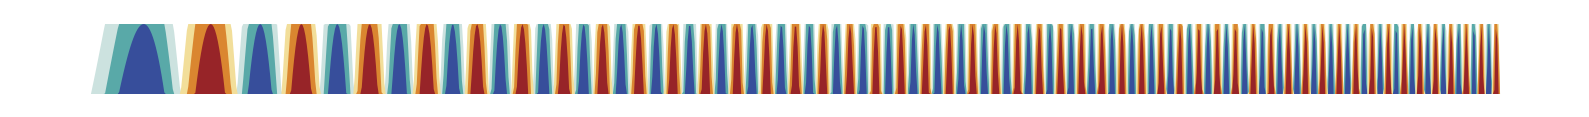

In [276]:
import time
import warnings
from itertools import chain
# import gc

import numpy as np
import pandas as pd

# # Make inline plots vector graphics instead of raster graphics
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, floor, log10

def horizon(row, i, cut):
    """
    Compute the values for the three 
    positive and negative intervals.
    """
    val = getattr(row, i)

    if np.isnan(val):
        for i in range(8):
            yield 0
        # for nan color
        yield cut
    else:
        if val < 0:
            for i in range(4):
                yield 0

        val = abs(val)
        for i in range(3):
            yield min(cut, val)
            val = max(0, val-cut)
        yield int(not isclose(val, 0, abs_tol=1e-8)) * cut

        if val >= 0:
            for i in range(4):
                yield 0

        # for nan color
        yield 0
    
def horizonplot(df, y=None, ax=None,
                cut=None, # float, takes precedence over quantile_span
                quantile_span = None,
                start='start',
                beginzero=True, 
                colors = ['#CCE2DF', '#59A9A8', '#374E9B', 'midnightblue',
                          '#F2DE9A', '#DA8630', '#972428', 'darkred',
                          '#D3D3D3']):
                # colours = ['#314E9F', '#36AAA8', '#D7E2D4'] + ['midnightblue'] + \
                #           ['#F5DE90', '#F5DE90', '#A51023'] + ['darkred'] + ['whitesmoke']):
                # colors = sns.color_palette("Blues", 3) + ['midnightblue'] + \
                #           sns.color_palette("Reds", 3) + ['darkred'] + ['lightgrey']):

    """
    Horizon bar plot made allowing multiple chromosomes and multiple samples.
    """

    # set cut if not set
    if cut is None:
        cut = np.max([np.max(df[y]), np.max(-df[y])]) / 3
    elif quantile_span:
        cut=max(np.abs(np.nanquantile(df[col], quantile_span[0])), 
                np.abs(np.nanquantile(df[col], quantile_span[1]))) / 3,

    # make the data frame to plot
    row_iter = df.itertuples()
    col_iterators = zip(*(horizon(row, y, cut) for row in row_iter))
    col_names = ['yp1', 'yp2', 'yp3', 'yp4', 
                 'yn1', 'yn2', 'yn3', 'yn4', 'nan']

    df2 = (df[[y, start]]
           .assign(**dict(zip(col_names, col_iterators)))
          )
    df2 = pd.DataFrame(dict((col, list(chain.from_iterable(zip(df2[col].values, df2[col].values)))) for col in df2))

    # make the plot
    with sns.axes_style("ticks"):

        # ingore UserWarning from seaborn that tight_layout is not applied
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            
            # first y tick
            ytic1 = round(cut/3, -int(floor(log10(abs(cut/3)))))

            for col_name, color in zip(col_names, colors):
                plt.setp(g.fig.texts, text="") # hack to make y facet labels align...
                # map barplots to each facet
                ax.fill_between(
                    df2[start], 
                    df2[col_name], 
                    y2=0,
                    color=color,
                    linewidth=0,
                    capstyle='butt')

n = 1000

fig, ax = plt.subplots(1, 1, figsize=(10, 0.5))

df = pd.DataFrame({'chrom': ['chr1']*n,
                'start': list(range(1*n)), 
                 'pi': list(np.sin(np.linspace(-np.pi, 10*np.pi, 1*n)))                   
                  })
sample = n
Fs = ci.max_chrom_size
# f = 50
f = np.linspace(5, 50, sample)
x = np.linspace(0, Fs, sample)
y = np.sin(2* np.pi * f * x / Fs)
df['pi'] = y


horizonplot(df, y='pi', ax=ax)
ax.set_axis_off()

In [247]:
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.artist import Artist
import matplotlib.gridspec as gridspec
from operator import sub
import random
import numpy as np
from collections import defaultdict
from itertools import cycle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import seaborn as sns
from matplotlib.axes import Axes

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        self.points = points

    def get_points(self):
        return self.points

    def nudge_y(self, nudge):
        for point in self.points:
            point.y += nudge
            
class GenomeIdeogram(object):

    d = {'axes.linewidth': 0.8, 'grid.linewidth': 0.64, 'lines.linewidth': 0.96, 
         'lines.markersize': 3.84, 'patch.linewidth': 0.64, 'xtick.major.width': 0.8,
         'ytick.major.width': 0.8, 'xtick.minor.width': 0.64, 'ytick.minor.width': 0.64,
         'xtick.major.size': 3.84, 'ytick.major.size': 3.84, 'xtick.minor.size': 2.56, 
         'ytick.minor.size': 2.56, 'font.size': 7.68, 'axes.labelsize': 7.68,
         'axes.titlesize': 7.68, 'xtick.labelsize': 7.04, 'ytick.labelsize': 7.04, 
         'legend.fontsize': 7.04, 'legend.title_fontsize': 7.68}
    
    chrom_lengths = {'hg19': {'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276, 
                              'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 
                              'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895,
                              'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 
                              'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 
                              'chr21': 48129895, 'chr22': 51304566, 'chrX': 155270560, 'chrY': 59373566},
                     'hg38': {'chr1': 248956422, 'chr2': 242193529, 'chr3': 198295559, 'chr4': 190214555, 
                              'chr5': 181538259, 'chr6': 170805979, 'chr7': 159345973, 'chr8': 145138636, 
                              'chr9': 138394717, 'chr10': 133797422, 'chr11': 135086622, 'chr12': 133275309, 
                              'chr13': 114364328, 'chr14': 107043718, 'chr15': 101991189, 'chr16': 90338345, 
                              'chr17': 83257441, 'chr18': 80373285, 'chr19': 58617616, 'chr20': 64444167, 
                              'chr21': 46709983, 'chr22': 50818468, 'chrX': 156040895, 'chrY': 57227415}}    

    # TODO: make the centromeres fit each assembly!
    centromeres = {
        'chr1':    (121700000, 125100000),
        'chr10':   (38000000, 41600000),
        'chr11':   (51000000, 55800000),
        'chr12':   (33200000, 37800000),
        'chr13':   (16500000, 18900000),
        'chr14':   (16100000, 18200000),
        'chr15':   (17500000, 20500000),
        'chr16':   (35300000, 38400000),
        'chr17':   (22700000, 27400000),
        'chr18':   (15400000, 21500000),
        'chr19':   (24200000, 28100000),
        'chr2':    (91800000, 96000000),
        'chr20':   (25700000, 30400000),
        'chr21':   (10900000, 13000000),
        'chr22':   (13700000, 17400000),
        'chr3':    (87800000, 94000000),
        'chr4':    (48200000, 51800000),
        'chr5':    (46100000, 51400000),
        'chr6':    (58500000, 62600000),
        'chr7':    (58100000, 62100000),
        'chr8':    (43200000, 47200000),
        'chr9':    (42200000, 45500000),
        'chrX':    (58100000, 63800000),
        'chrY':    (10300000, 10400000)}                     

    
    def __init__(self, axes_height_inches=1, axes_width_inches=12, hspace=0, ylim=(0, 1), 
                 rel_font_height=0.05, assembly:str='hg38'):

        self.ideogram_base = None
        self.ideogram_height = None
        self.legend_handles = []
        
        self.chr_names = [f'chr{x}' for x in list(range(1, 23))+['X', 'Y']]
        self.chr_sizes = [self.chrom_lengths[assembly][chrom] for chrom in self.chr_names]
        self.max_chrom_size = max(self.chr_sizes)
        nr_rows = len(self.chr_names) - 1
        self.aspect = axes_height_inches / axes_width_inches
        axes_width = self.max_chrom_size
        axes_height = self.aspect * self.max_chrom_size
        fig_height_inches = axes_height_inches * (nr_rows-1) + hspace * (nr_rows-1)
        fig_width_inches = axes_width_inches #fig_height_inches / (nr_rows-1) / aspect 
        figsize = (fig_width_inches, fig_height_inches)
        point_size = 1/72
        self.ylim = ylim
        self.font_size = rel_font_height * axes_height_inches / point_size

        self.fig = plt.figure(figsize=figsize)
        plt.subplots_adjust(hspace=0)
        
        with plt.rc_context(self.d):
        
            nr_rows, nr_cols = len(self.chr_names)-2+1, 2
    
            # fig = plt.figure(figsize=figsize)

            end_padding = 300000
            
            # gs = matplotlib.gridspec.GridSpec(nr_rows, 25)
            gs = matplotlib.gridspec.GridSpec(nr_rows+1, 25, height_ratios=[1e-2]+[1]*nr_rows)
            gs.update(wspace=0, hspace=hspace) 

            dummy_ax = plt.subplot(gs[0, :])
            xlim = (-end_padding, self.max_chrom_size+end_padding)
            dummy_ax.set_xlim(xlim)
            # dummy_ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

            dummy_ax.spines['top'].set_visible(True)
            dummy_ax.xaxis.tick_top()
            dummy_ax.xaxis.set_label_position('top') 
            dummy_ax.yaxis.set_ticks_position('none')
            dummy_ax.set_yticklabels([])
        
            ax_list = [plt.subplot(gs[i, :]) for i in range(1, nr_rows-2)]
            ax_list.append(plt.subplot(gs[nr_rows-2, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-1, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-2, 9:]))
            ax_list.append(plt.subplot(gs[nr_rows-1, 9:]))

            self.ax_list = ax_list
            self.chr_axes = dict(zip(self.chr_names, self.ax_list))
    
            for ax in self.ax_list[:-4]:
                xlim = (-end_padding, self.max_chrom_size+end_padding)
                scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect
                ax.set_xlim(xlim)
                ax.set_ylim(scaled_y_lim)
            for ax in ax_list[-4:]:
                xlim = (-end_padding, ((25-9)/25)*self.max_chrom_size+end_padding)
                scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect
                ax.set_xlim(xlim)
                ax.set_ylim(scaled_y_lim)
    
            for i in range(len(self.ax_list)):
                chrom = self.chr_names[i]
                ax = ax_list[i]
                
                start, end = 0, self.chr_sizes[i]
                ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

                # ax.spines['top'].set_visible(False)
                # ax.spines['right'].set_visible(False)
                # ax.spines['bottom'].set_visible(False)
                # ax.spines['left'].set_visible(False)
                # ax.set_ylim((0, 3))
                # ax.set_ylim((0, 5))
    
                if i in [20, 21]:   
                    x = -3500000 * 10 / figsize[1]
                else:
                    x = -2000000 * 10 / figsize[1]

                ax.text(x, self.map_y(-sub(*self.ylim), ax)/2, chrom.replace('chr', ''), fontsize=7, verticalalignment='center', horizontalalignment='right', weight='bold')
    
                # h = ax.set_ylabel(chrom)
                # h.set_rotation(0)
                ax.set_yticklabels([])
    
                # if i == 0:
                #     ax.spines['top'].set_visible(True)
                #     ax.xaxis.tick_top()
                #     ax.xaxis.set_label_position('top') 
                #     ax.yaxis.set_ticks_position('none')
                # elif i == len(ax_list)-1:
                if i == len(self.ax_list)-1:
                    ax.xaxis.tick_bottom()
                    ax.spines['bottom'].set_visible(True)                    
                    ax.yaxis.set_ticks_position('none')
                    ax.yaxis.set_visible(False)
                    ax.set_yticklabels([])
                else:
                    ax.set_xticklabels([])
                    ax.xaxis.set_ticks_position('none')
                    ax.yaxis.set_ticks_position('none')
                    # ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    def draw_chromosomes(self, base=0.05, height=0.25, facecolor='#EBEAEA', edgecolor='black', linewidth=0.7, **kwargs):

        self.ideogram_base = base
        self.ideogram_height = height
        
        with plt.rc_context(self.d):

            for i in range(len(self.ax_list)):
                chrom = self.chr_names[i]
                ax = self.ax_list[i]
                start, end = 0, self.chr_sizes[i]                

                ideogram_base = self.map_y(base, ax)
                ideogram_height = self.map_y(height, ax)
                
                # draw chrom
                g = ax.add_patch(patches.Rectangle((start, ideogram_base), end-start, ideogram_height, 
                                           # fill=False,
                                           facecolor=facecolor,
                                           edgecolor='none',
                                           zorder=0,
                                           linewidth=linewidth,
                                           **kwargs
                                          ))
                g = ax.add_patch(patches.Rectangle((start, ideogram_base), end-start, ideogram_height, 
                                           # fill=False,
                                           facecolor='none',
                                           edgecolor=edgecolor,
                                           zorder=0.5,
                                           linewidth=linewidth,
                                           **kwargs
                                          ))                
    
                # draw centromere
                cent_start, cent_end = self.centromeres[chrom]
                ymin, ymax = ax.get_ylim()
                ax.add_patch(patches.Rectangle((cent_start, ymin), cent_end-cent_start, ymax, 
                                           fill=True, color='white',
                                           zorder=1))
                xy = [[cent_start, ideogram_base], [cent_start, ideogram_base+ideogram_height], [cent_end, ideogram_base], [cent_end, ideogram_base+ideogram_height]]
                g = ax.add_patch(patches.Polygon(xy, closed=True, zorder=2, fill=True,
                                         # color='#666666',
                                         color='#777777',
                                        ))


    def is_polygons_intersecting(self, a, b):
        for x in range(2):
            polygon = a if x == 0 else b
    
            for i1 in range(len(polygon.get_points())):
                i2 = (i1 + 1) % len(polygon.get_points())
                p1 = polygon.get_points()[i1]
                p2 = polygon.get_points()[i2]
    
                normal = Point(p2.y - p1.y, p1.x - p2.x)
    
                min_a = float('inf')
                max_a = float('-inf')
    
                for p in a.get_points():
                    projected = normal.x * p.x + normal.y * p.y
                    min_a = min(min_a, projected)
                    max_a = max(max_a, projected)
    
                min_b = float('inf')
                max_b = float('-inf')
    
                for p in b.get_points():
                    projected = normal.x * p.x + normal.y * p.y
                    min_b = min(min_b, projected)
                    max_b = max(max_b, projected)
    
                if max_a < min_b or max_b < min_a:
                    return False
    
        return True

    
    def scaled_y_lim(self, ax):
        # xlim = (0, max_chrom_size)
        xlim = ax.get_xlim()
        return xlim[0] * self.aspect, xlim[1] * self.aspect
    

    def map_y(self, y, ax, bottom=0, top=1):
        miny, maxy = ax.get_ylim()

        return y * (top - bottom) * (maxy - miny) / (self.ylim[1] - self.ylim[0]) + bottom * (maxy - miny)
        # zero = -miny
        # if y >= 0:
        #     return y * (top - max(bottom, zero)) * (maxy - zero) / (self.ylim[1] - self.ylim[0]) + max(bottom, zero) * (maxy - zero)
        # else:
        #     return y * (min(top, zero) - bottom) * (zero - miny) / (self.ylim[1] - self.ylim[0]) + min(top, zero) * (zero - miny)

        

    
    def draw_text(self, x_pos, y_pos, text, ax, color='black', y_line_bottom=0):
        y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
        
        t = ax.text(x_pos, y_pos, text, fontsize=self.font_size, 
                    color=color,
                    horizontalalignment='left',
                    verticalalignment='bottom', 
                    rotation=45, zorder=3, 
                    bbox=dict(boxstyle='square,pad=0', 
                              fc='none', 
                              # fc=color, alpha=0.4,
                              ec='none'))
        ax.plot((x_pos, x_pos, x_pos+y_unit/40),
                (y_line_bottom, y_pos, y_pos+y_unit/40), 
                linewidth=0.5, 
                # color='darkgray', 
                color=color,
                alpha=0.3,
                zorder=2)
    
    
    def get_polygon(self, text:str, x_pos:int, y_pos:float, ax:matplotlib.axes.Axes) -> Polygon:
    
        y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
    
        y_pos = y_pos * y_unit
        
        t = ax.text(x_pos, y_pos, text, fontsize=self.font_size,
                    horizontalalignment='left',
                    verticalalignment='bottom', 
                    rotation=0, zorder=3, 
                    # bbox=dict(boxstyle='square,pad=0', 
                    bbox=dict(boxstyle='square', 
                              fc='none', ec='none', alpha=0.4))
        
        transf = ax.transData.inverted()
        bb = t.get_window_extent(renderer = self.fig.canvas.get_renderer())
        bbt = bb.transformed(transf)
        coords = bbt.get_points()
        
        Artist.remove(t)
        
        (x0, y0), (x1, y1) = coords
        pad = (y1 - y0)/5
        coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
            
        x, y = zip(*coords)
        df = pd.DataFrame(dict(x=x, y=y))
        df['y'] -= y_pos
        df['x'] -= x_pos
        dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
        df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
        df['x'] = dfx
        df['y'] += y_pos
        df['x'] += x_pos
            
        coords = np.array(list(zip(df.x, df.y)))
        
        x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]
    
        df['x'] = df.x + np.array([-pad, -pad, pad, pad])
        df['y'] = df.y + np.array([-pad, pad, pad, -pad])
        
        return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])
        

    # def add_labels(self, data, labels='name', chrom='chrom', x='pos'):
    def add_labels(self, annot, y0=0, y1=0.2):

        chrom_annot = defaultdict(list)
        for a in annot:
            chrom_annot[a[0]].append(a[1:])
            
        for chrom, annot in chrom_annot.items():
            ax = self.chr_axes[chrom]

            annot = sorted(annot, reverse=True)

            y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
        
            polybuff = []
            for pos, name, *args in annot:
                x, y, poly = self.get_polygon(name, pos, y1, ax)
                while any(self.is_polygons_intersecting(poly, p) for p in polybuff):
                    nudge = 0.01 * y_unit
                    y += nudge
                    poly.nudge_y(nudge)

                self.draw_text(x, y, name, ax, *args, y_line_bottom=y0*y_unit)

                polybuff.append(poly)
                if len(polybuff) > 10:
                    del polybuff[0]
        
            z = 10
            for i, t in enumerate(reversed(ax.texts)):
                t.set_zorder(z+i)


    def add_segments(self, annot, base=None, height=None, label=None,
                    min_visible_width:int=200000, color='black'):

        if label is not None:
            self.legend_handles.append(Patch(facecolor=color,label=label))
        
        if base is None:
            base = self.ideogram_base
        if height is None:
            height = self.ideogram_height            
        
        chrom_annot = defaultdict(list)
        for a in annot:
            chrom_annot[a[0]].append(a[1:])
            
        for chrom, annot in chrom_annot.items():
            ax = self.chr_axes[chrom]

            annot = sorted(annot, reverse=True)

            y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)

            for start, end in annot:
                scaled_base = base * y_unit
                scaled_height = height * y_unit
                
                width = end - start
            
                if width < min_visible_width:
                    start -= min_visible_width/2
                    width += min_visible_width
        
                rect = patches.Rectangle((start, scaled_base), width, scaled_height, linewidth=1, edgecolor='none', facecolor=color, zorder=3)
                self.chr_axes[chrom].add_patch(rect)    


    def add_vlines(self, step=1000000, color='black', linewidth=0.1, zorder=100, **kwargs):
        for i, ax in enumerate(self.ax_list):

            s, e = self.centromeres[self.chr_names[i]]
            
            ax.vlines([x for x in range(0, self.chr_sizes[i], step) if x < s or x > e], 
                      ymin=self.map_y(self.ideogram_base, ax), ymax=self.map_y(self.ideogram_base+self.ideogram_height, ax), 
                      linewidth=linewidth, color=color, zorder=zorder, **kwargs)
    
    
    def map_method(self, fun, data=None, chrom_col='chrom', yaxis=(0, 1), **kwargs):
        bottom, top = yaxis
        grouped = data.groupby(chrom_col)
        for chrom, group in grouped:
            ax = self.chr_axes[chrom]
            scaled_y_lim = ax.get_ylim()
            if 'ylim' in kwargs:
                dy = -sub(*ylim)
            else:
                dy = -sub(*self.ylim)
            df = group.copy()
            df['y'] -= df.y.min()
            df['y'] /= df.y.max()
            df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
            x = df.x
            y = df.y
            del kwargs['x']
            del kwargs['y']

            def method_not_found(): # just in case we dont have the function
                print('No Function '+fun+' Found!')
            fun_name = fun.__name__
            method = getattr(ax, fun_name, method_not_found) 
            g = method(x, y, **kwargs)
            plt.xlabel('')
            plt.ylabel('')

    
    def map_fun(self, fun, data=None, chrom_col='chrom', yaxis=(0, 1), **kwargs):
        bottom, top = yaxis
        grouped = data.groupby(chrom_col)
        for chrom, group in grouped:
            ax = self.chr_axes[chrom]
            scaled_y_lim = ax.get_ylim()
            if 'ylim' in kwargs:
                dy = -sub(*ylim)
            else:
                dy = -sub(*self.ylim)
            df = group.copy()
            df['y'] -= df.y.min()
            df['y'] /= df.y.max()
            df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
            g = fun(df, ax=ax, **kwargs)
            plt.xlabel('')
            plt.ylabel('')

    def legend(self, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, **kwargs):
        for ax in self.ax_list:
            handles, labels = ax.get_legend_handles_labels()
            if self.legend_handles:
                handles = self.legend_handles + handles
            ax.legend(handles=handles, loc=loc, bbox_to_anchor=bbox_to_anchor, frameon=frameon, **kwargs)


class ChromIdeogram(GenomeIdeogram):

    def __init__(self, chrom, axes_height_inches=1, axes_width_inches=12, hspace=None, ylim=(0, 1), 
                 rel_font_height=0.05, assembly:str='hg38'):

        self.ideogram_base = None
        self.ideogram_height = None
        self.legend_handles = []
        self.height_ratios = [1]

        self.chr_names = [chrom]
        self.chr_sizes = [self.chrom_lengths[assembly][chrom] for chrom in self.chr_names]
        self.max_chrom_size = max(self.chr_sizes)
        nr_rows = 1
        self.aspect = axes_height_inches / axes_width_inches
        axes_width = self.max_chrom_size
        axes_height = self.aspect * self.max_chrom_size
        fig_height_inches = axes_height_inches 
        fig_width_inches = axes_width_inches
        figsize = (fig_width_inches, fig_height_inches)
        point_size = 1/72
        self.ylim = ylim
        self.font_size = rel_font_height * axes_height_inches / point_size

        self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
        if hspace is not None:
            plt.subplots_adjust(hspace=hspace)

        plt.minorticks_on()
        
        with plt.rc_context(self.d):
        
            nr_rows, nr_cols = 1, 1
    
            # fig = plt.figure(figsize=figsize)

            end_padding = 300000
            
            # gs = matplotlib.gridspec.GridSpec(nr_rows, 25)
            gs = matplotlib.gridspec.GridSpec(1, 1)
            gs.update(wspace=0, hspace=hspace) 
        
            ax_list = [self.ax]

            self.ax_list = ax_list
            self.chr_axes = dict(zip(self.chr_names, self.ax_list))

            for i in range(len(self.ax_list)):
                chrom = self.chr_names[i]
                ax = ax_list[i]                
                xlim = (-end_padding, self.chr_sizes[i]+end_padding)
                scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect
                ax.set_xlim(xlim)
                ax.set_ylim(scaled_y_lim)                
   
                # start, end = 0, self.chr_sizes[i]
                # ax.set_xlim(start, end)
                ax.spines[['right', 'top', 'left']].set_visible(False)
                x = -2000000 * 10 / figsize[1]
                ax.set_yticklabels([])
                ax.set_xticks(np.arange(0, self.chr_sizes[i]+1, 10_000_000))
                ax.xaxis.tick_bottom()
                ax.spines['bottom'].set_visible(True)                    
                ax.yaxis.set_ticks_position('none')
                ax.yaxis.set_visible(False)
                ax.set_yticklabels([])


    def add_axes(self, nr_axes=1, height_ratio=1.0, hspace=None):

        new_axes = []
        for _ in range(nr_axes):
        
            gs = self.ax.get_gridspec()
            row = gs.nrows + 1
            self.height_ratios.append(height_ratio)
            gs = gridspec.GridSpec(row, 1, height_ratios=self.height_ratios, hspace=hspace)
            for i, ax in enumerate(self.fig.axes):
                ax.set_position(gs[i].get_position(self.fig))
                ax.set_subplotspec(gs[i])
            new_ax = self.fig.add_subplot(gs[row-1], sharex=ax)
            self.fig.set_figheight(self.fig.get_figheight()*sum(self.height_ratios)/sum(self.height_ratios[:-1]))
            new_ax.spines[['right', 'top']].set_visible(False)
            new_axes.append(new_ax)
        if nr_axes == 1:
            return new_axes[0]
        else:
            return new_axes
            

In [310]:
_names = random.choices(['AKAP4', 'DYNLT3', 'MAGEA4', 'TP53'], k=200)
_pos = sorted(np.random.randint(1, 250000000, 200).tolist())
# _colors = random.choices(['blue', 'brown', 'green', 'orange'], k=200)
# annot = list(zip(['chr1']*200, _pos, _names, cycle(sns.color_palette('twilight', 5).as_hex())))
_colors = ['black']*200
annot = list(zip(['chr1']*200, _pos, _names, 
    _colors
    # _colors = random.choices(['blue', 'brown', 'green', 'orange'], k=200)
                 
            ))

sample = 1000

Fs = ci.max_chrom_size
# f = 50
f = np.linspace(5, 50, sample)
x = np.linspace(0, Fs, sample)
y = np.sin(2* np.pi * f * x / Fs)

# x = np.linspace(1, 250000000, sample)
# rng = np.random.default_rng()
# y = rng.normal(scale=1, size=x.size)

chrom = ['chr1']*sample

df = pd.DataFrame(dict(x=x, y=y, chrom=chrom))
df['start'] = df.x

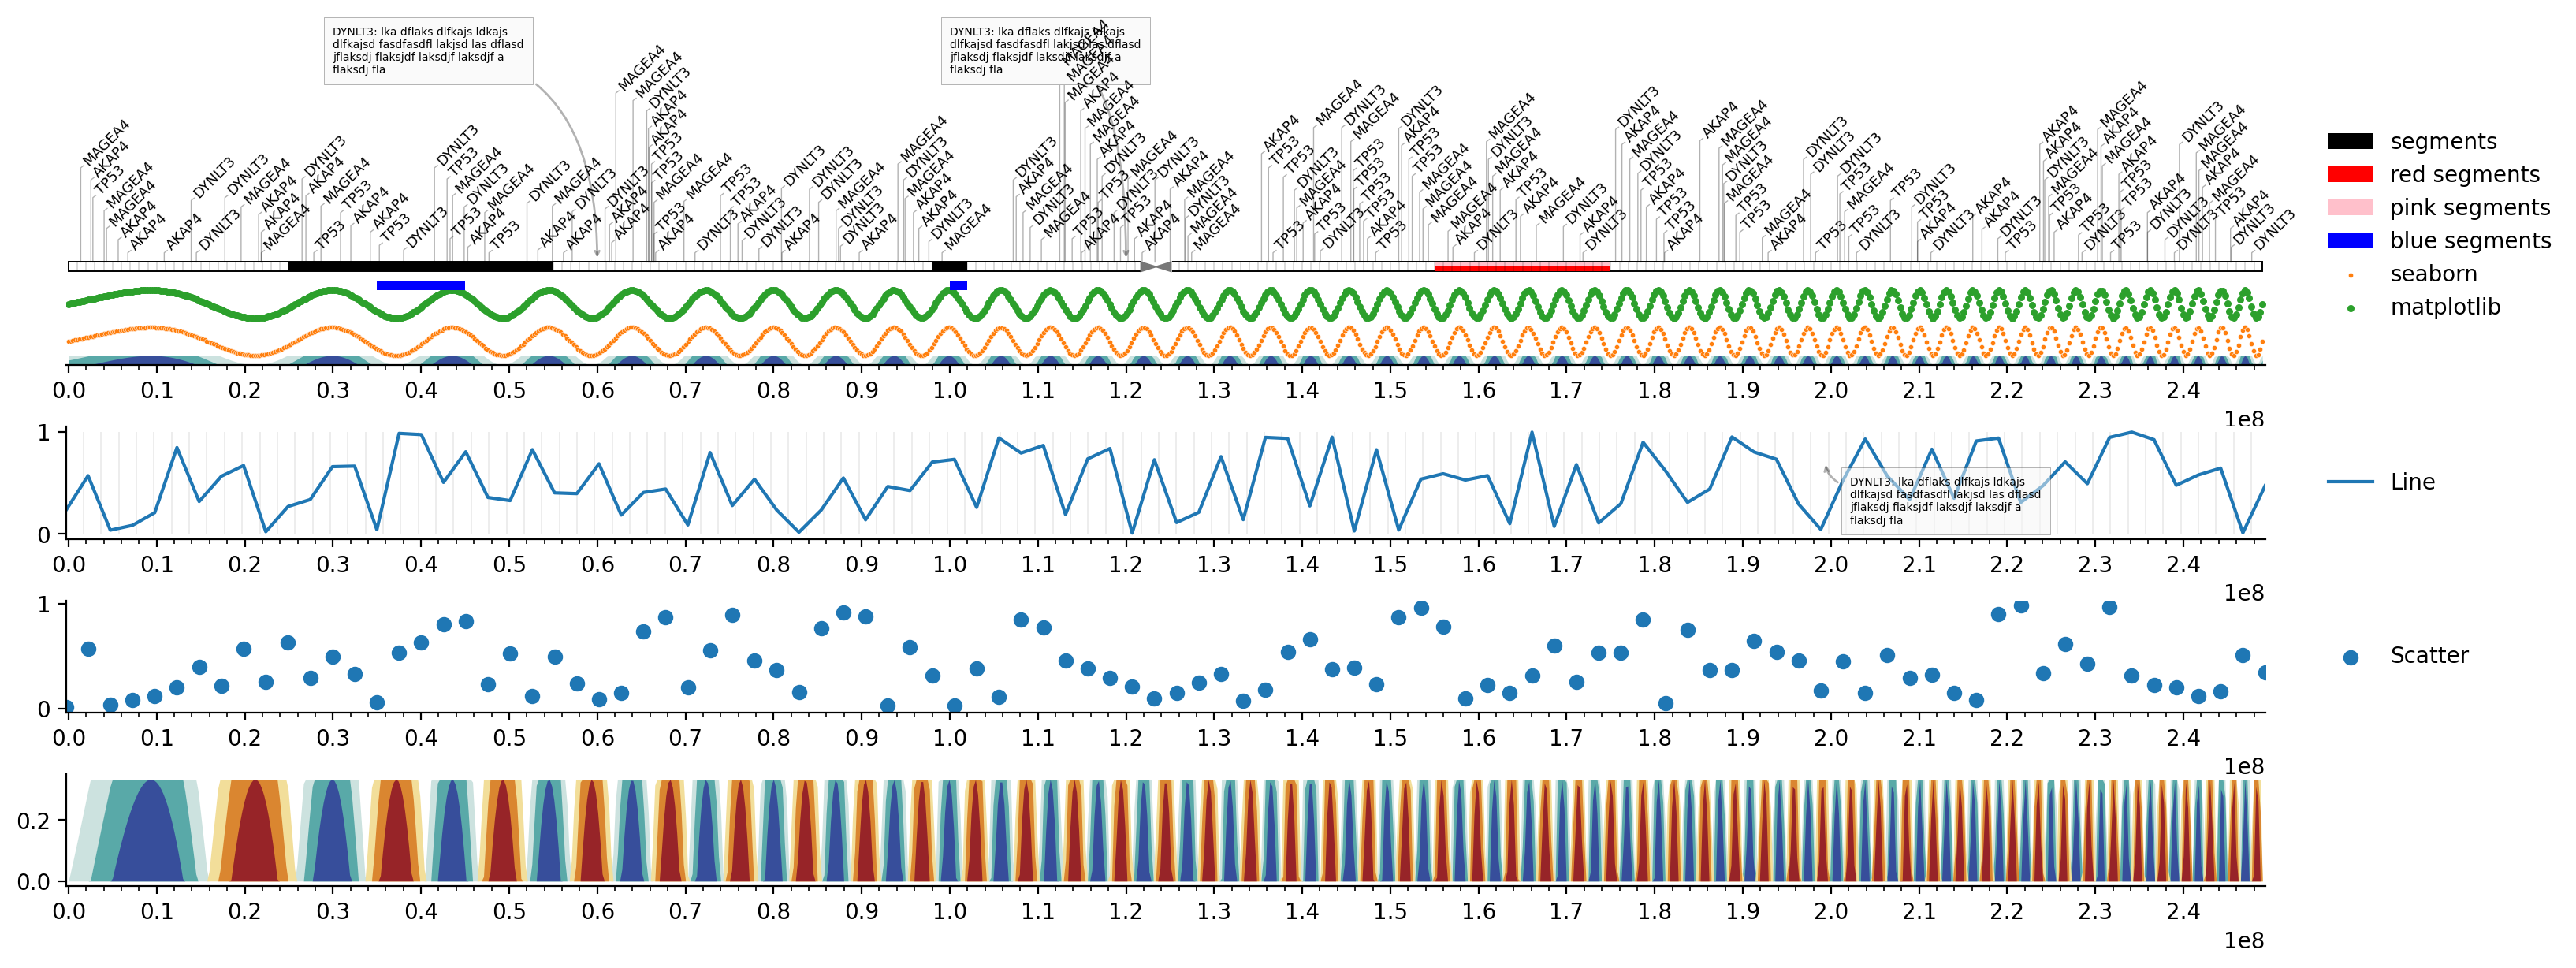

In [316]:


##########################################################################################
# interface
##########################################################################################

ci = ChromIdeogram('chr1', axes_width_inches=18, axes_height_inches=3, ylim=(0, 3), rel_font_height=0.03) # plots chromosome

# ci.draw_chromosomes(base=1, height=0.10, facecolor='lightgray')
ci.draw_chromosomes(base=1, height=0.10, facecolor='none')


ci.map_fun(horizonplot, data=df, y='y', yaxis=(0, 0.3))


ci.add_labels(annot, y0=1.1, y1=1.2)
ci.add_segments([('chr1', 25e6, 55e6), ('chr1', 98e6, 102e6)], label='segments')
ci.add_segments([('chr1', 155e6, 175e6)], color='red', height=0.05, label='red segments')
ci.add_segments([('chr1', 155e6, 175e6)], color='pink', base=1.05, height=0.05, label='pink segments')
ci.add_segments([('chr1', 35e6, 45e6), ('chr1', 100e6, 102e6)], color='blue', base=0.8, height=0.1, label='blue segments')

ci.add_vlines()

# plot using function that takes data and column name keyword args for dimensions (like seaborn's sns.scatterplot)
ci.map_fun(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.1, 0.4), s=5, c='C1', label='seaborn')

# plot using matplotlib Axes method that x and y positional arguments (like matplotlib's Axes.scatter)
ci.map_method(Axes.scatter, data=df, x='x', y='y', yaxis=(0.5, 0.8), s=5, c='C2', label='matplotlib')

ci.legend()

##########################################################################################
# add axis
##########################################################################################

new_ax, new_ax2, new_ax3 = ci.add_axes(3, height_ratio=0.4, hspace=0.4)


new_ax.vlines(list(range(*map(int, new_ax.get_xlim()), 2_000_000)), *new_ax.get_ylim(), color='gray', linewidth=0.1)

new_ax.plot(np.linspace(*new_ax.get_xlim(), 100), np.random.random(100), label='Line')
new_ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize="10", frameon=False) ;

new_ax2.scatter(np.linspace(*new_ax.get_xlim(), 100), np.random.random(100), label='Scatter')
new_ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize="10", frameon=False) ;

horizonplot(df, y='y', ax=new_ax3)


##########################################################################################
# info annotation
##########################################################################################

from matplotlib.text import OffsetFrom
import textwrap

import textwrap

strs = "DYNLT3: lka dflaks dlfkajs ldkajs dlfkajsd fasdfasdfl lakjsd las dflasd jflaksdj flaksjdf laksdjf laksdjf a flaksdj fla"

annot_kwargs=dict(fontsize=5, ha="left", va="bottom",
             bbox=dict(fc="0.97", alpha=0.5, linewidth=0.2),
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.3))
                            
ci.ax.annotate(textwrap.fill(strs, 40), xy=(60000000, ci.map_y(1.1, ci.ax)), xytext=(30000000, ci.map_y(3.1, ci.ax)), xycoords="data", **annot_kwargs)
           
ci.ax.annotate(textwrap.fill(strs, 40), xy=(120000000, ci.map_y(1.1, ci.ax)), xytext=(100000000, ci.map_y(3.1, ci.ax)), xycoords="data", **annot_kwargs)

new_ax.annotate(textwrap.fill(strs, 40), xy=(0.8, 0.7), xytext=(800, 200), xycoords="axes fraction",
             textcoords=OffsetFrom(ax.bbox, (0, 0), "points"), **annot_kwargs) ;

# the issue seems to be that I compute ylimits using the input data to horizonplot, not the data it plots...

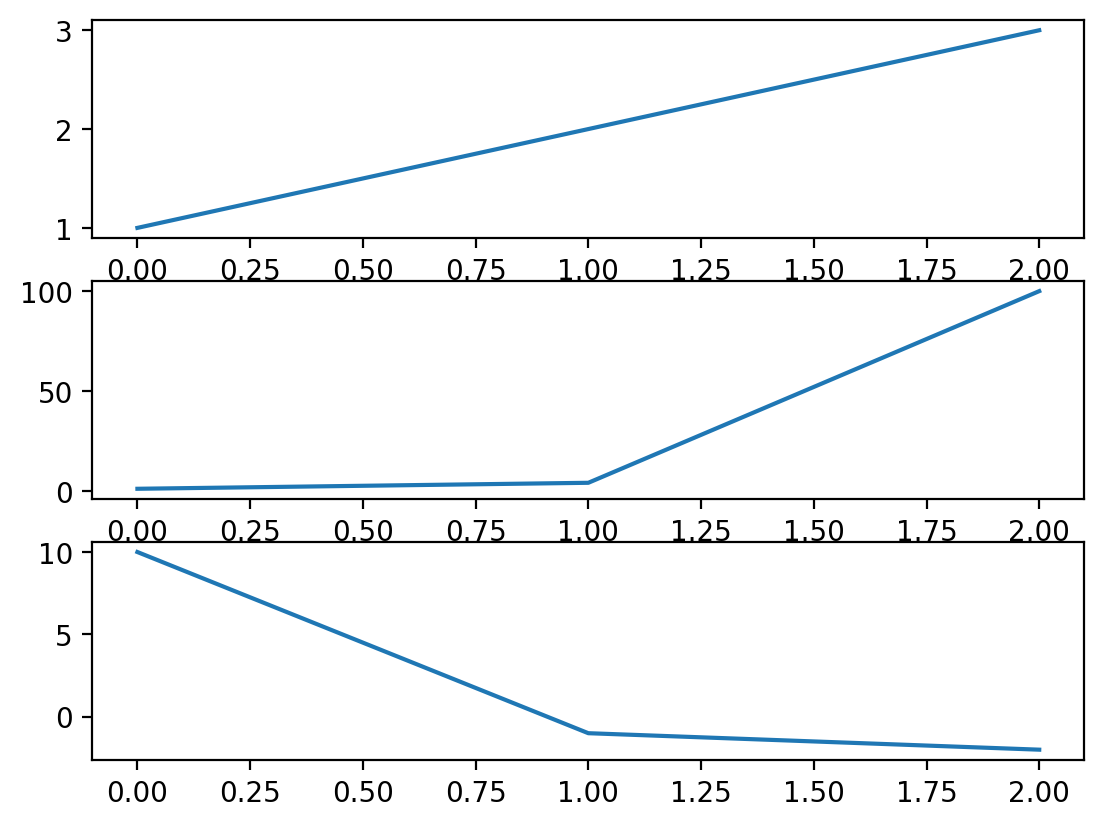

In [38]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


class DrawExample():

    def __init__(self, initial_data) -> None:
        """Constructs a DrawExample for one column and multiple rows.

        Note that subplots are added to the bottom.
        """
        self.fig = plt.figure()

        # Start with one subplot
        self.row = 1
        ax = self.fig.add_subplot(self.row, 1, 1)
        ax.plot(initial_data)

    def plot_bottom(self, data: list) -> None:
        """Plots the data to a new subplot at the bottom."""
        self.row += 1
        gs = gridspec.GridSpec(self.row, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        new_ax = self.fig.add_subplot(gs[self.row-1])
        new_ax.plot(data)

    def show(self) -> None:
        plt.show()


draw = DrawExample([1, 2, 3])
draw.plot_bottom([1, 4, 100])
draw.plot_bottom([10, -1, -2])
draw.show()

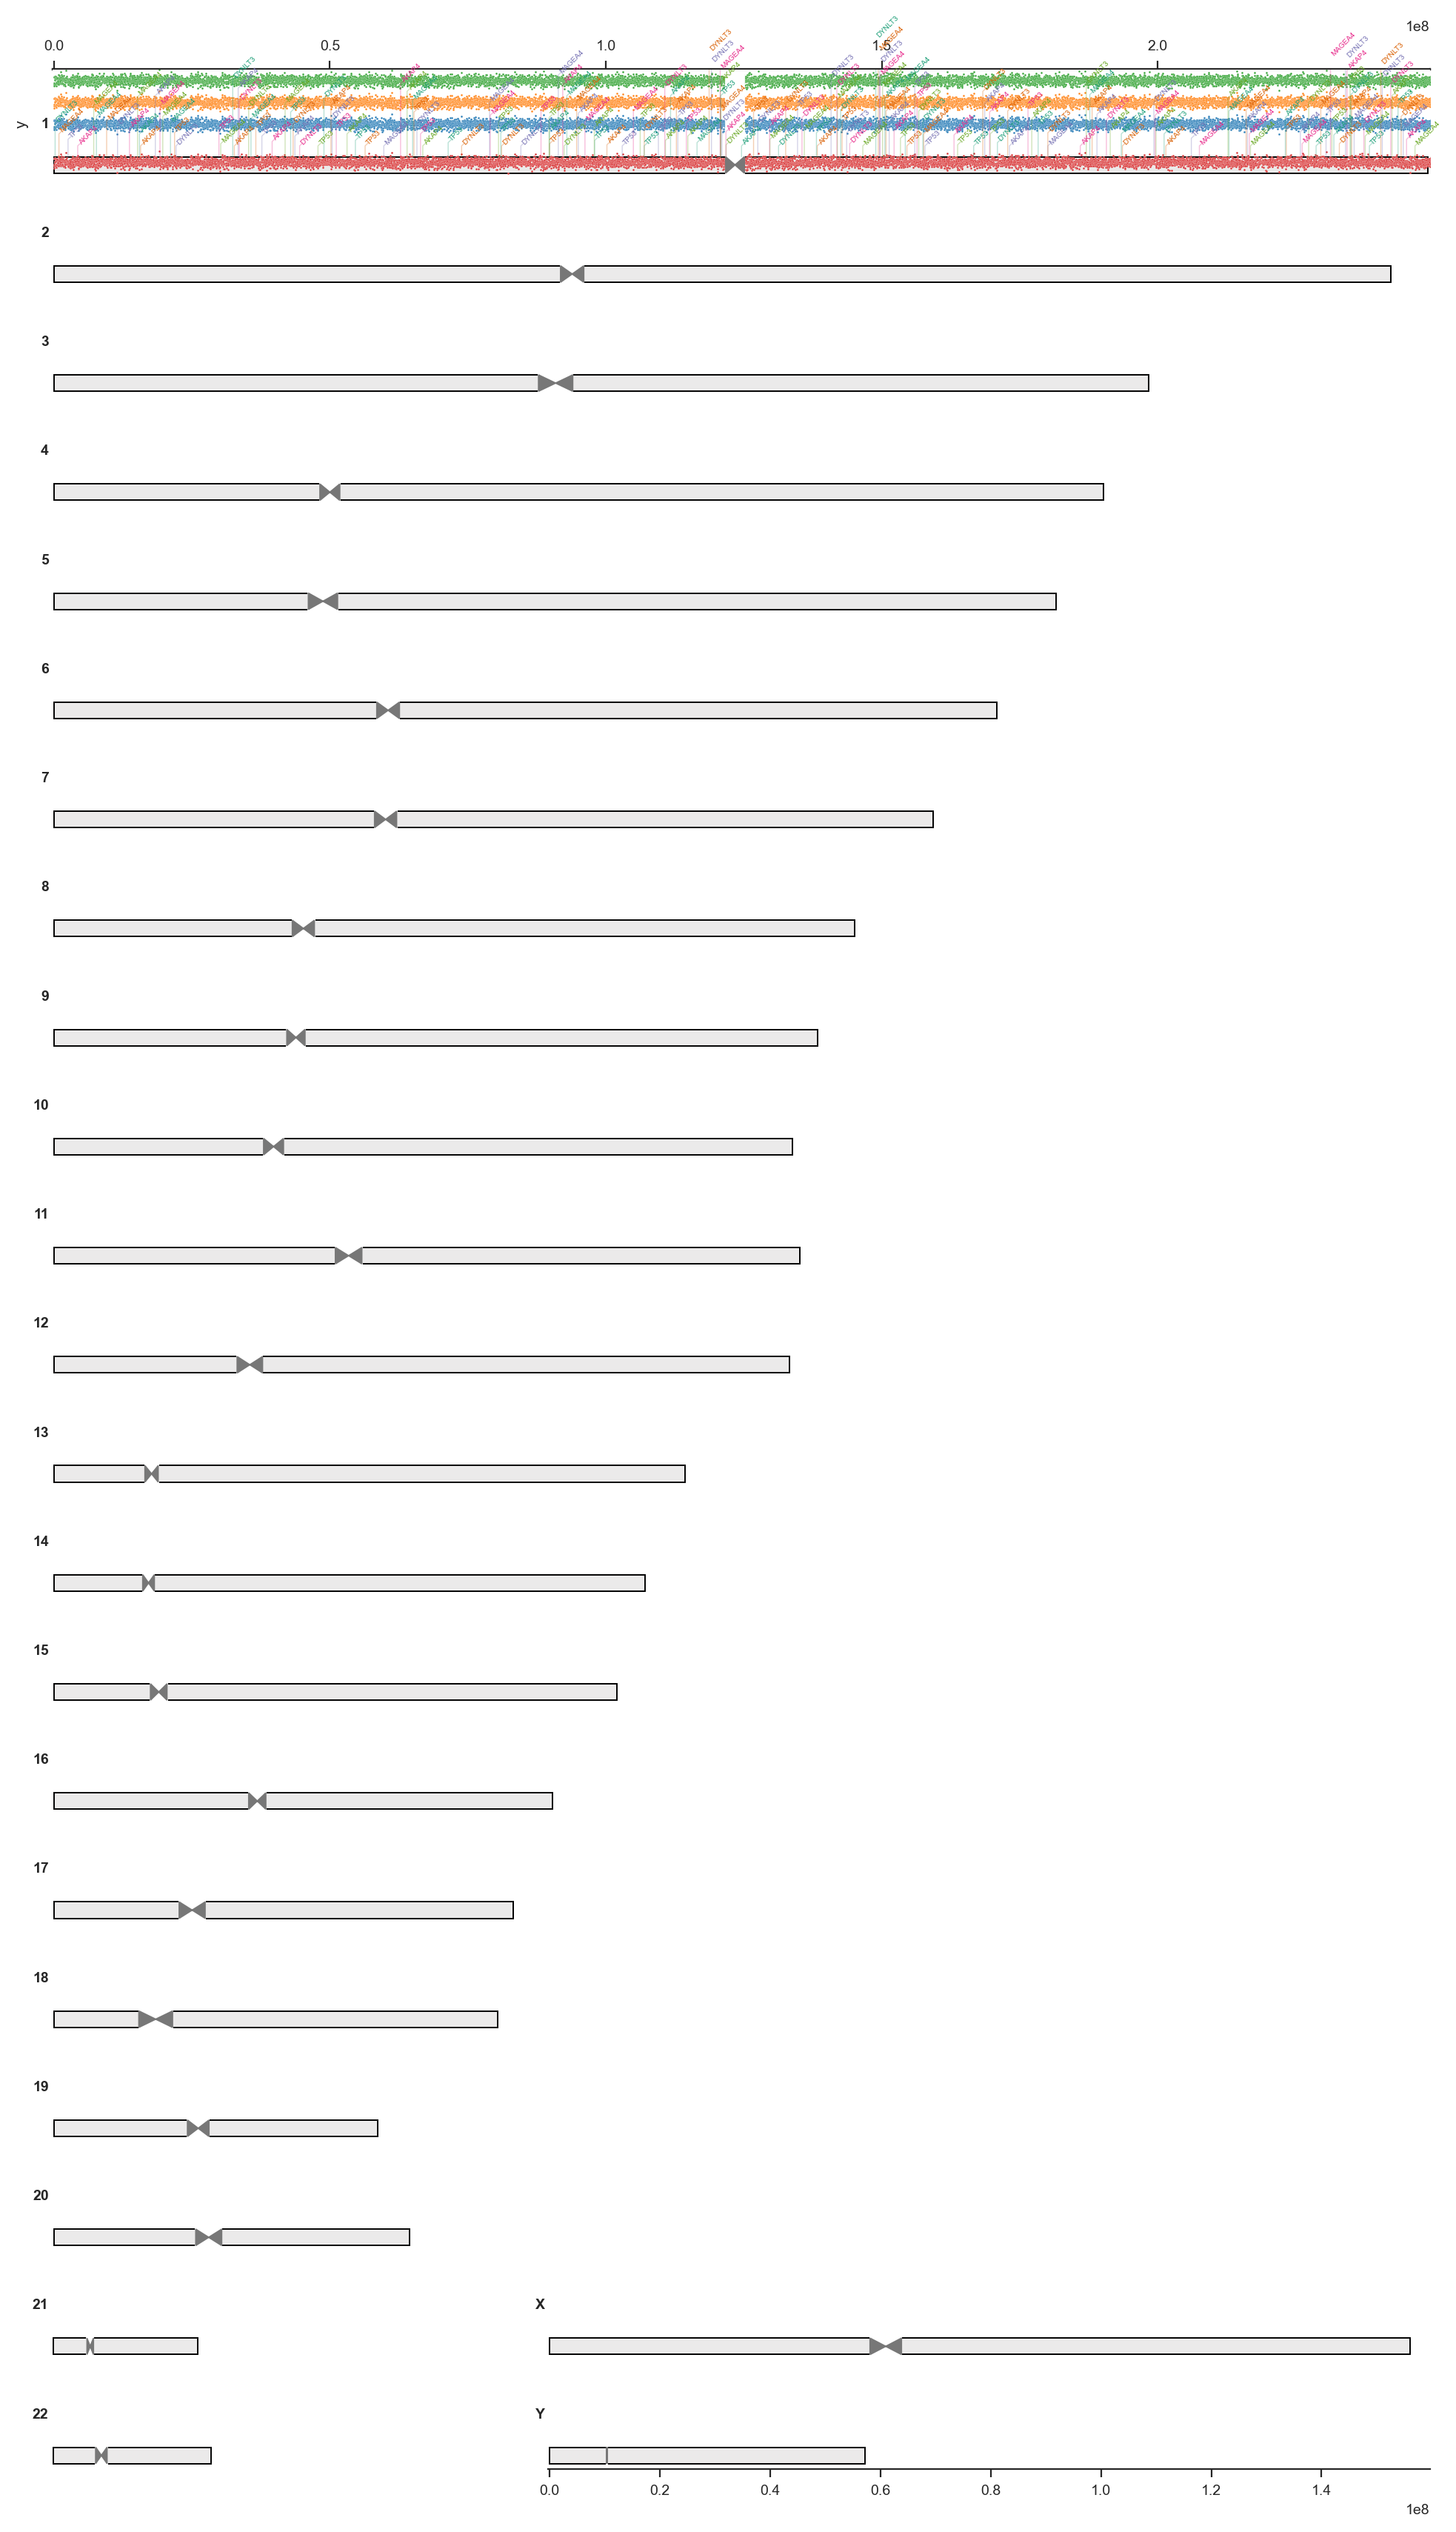

In [50]:
ci = GenomeIdeogram() # plots chromosome
ci.draw_chromosomes(base=0.05, height=0.15)
ci.add_labels(annot, y0=0.2, y1=0.3)
#ci.map(plt.scatter, data=df, x='x', y='y', yaxis=(0.5, 0.7))
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.4, 0.6), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.6, 0.8), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.8, 1.0), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.05, 0.25), s=1)

In [799]:
# import pandas as pd
# import math
# from matplotlib.artist import Artist


# axes_height = 1e4 # relative to length of chrom one
# max_chrom_size = 1e5
# aspect = axes_height / chrom_size

# fig_width_inches = 8
# axes_height_inches = fig_width * aspect
# fig_height = axes_height_inches * nr_rows

# nr_rows = 11
# fig, axes = plt.subplots(nr_rows, 1, figsize=(fig_width, fig_width*aspect*nr_rows), sharex=True, sharey=True)
# plt.subplots_adjust(hspace=0)
# ax = axes[0]

# xlim = (0, max_chrom_size)
# ylim = (0, 6)
# scaled_y_lim = xlim[0] * aspect, xlim[1] * aspect
# ax.set_xlim(xlim)
# ax.set_ylim(scaled_y_lim)
# plt.yticks([])
# y_unit = -sub(*scaled_y_lim) / -sub(*ylim)

# rel_font_height = 0.1
# font_size = rel_font_height * axes_height_inches / point_size


# def draw_text(x_pos, y_pos, text, font_size, rel_font_height, ax, y_line_bottom=0):
 
#     ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=45, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#     (_, a), (_, b) = ax.transAxes.transform([(0, 0), (0, rel_font_height / 2)])
#     z = b - a    
#     z = 300
#     z = y_unit/6

#     ax.plot((x_pos, x_pos, x_pos+z),
#             (y_line_bottom, y_pos, y_pos+z), 
#             linewidth=0.5, color='gray')


# def get_polygon(text:str, x_pos:int, y_pos:float, font_size:float, ax:matplotlib.axes.Axes) -> Polygon:

#     y_pos = y_pos * y_unit
#     # x_pos, y_pos = chrom_size/2, 2*y_unit
    
#     # ax.scatter([x_pos], [y_pos], marker='X', color='black')
    
    
#     t = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=0, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none', alpha=0.4))
#     # t.set_visible(False)
    
#     transf = ax.transData.inverted()
#     bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
#     bbt = bb.transformed(transf)
#     coords = bbt.get_points()
    
#     Artist.remove(t)
    
#     (x0, y0), (x1, y1) = coords
#     coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
#     # ax.scatter(*coords.T, c='red')
    
#     # ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)
    
#     x, y = zip(*coords)
#     df = pd.DataFrame(dict(x=x, y=y))
#     df['y'] -= y_pos
#     df['x'] -= x_pos
#     dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
#     df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
#     df['x'] = dfx
#     df['y'] += y_pos
#     df['x'] += x_pos
    
#     #df['x'] -= df['x'][1] - df['x'][0]
    
#     coords = np.array(list(zip(df.x, df.y)))
    
#     x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]
#     # _ = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#     #             horizontalalignment='left',# weight='bold',
#     #             verticalalignment='bottom', 
#     #             rotation=45, zorder=3, 
#     #             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
    
#     # ax.scatter(*coords.T, c='blue')
    
#     # ax.plot(*zip(*coords), linewidth=0.2)

#     return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])


# annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/200))]

# for i, ax in enumerate(axes):
#     annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/(10*(i+1))))]

#     polybuff = []
#     for pos, name in annot:
#         x, y, poly = get_polygon(name, pos, 1, rel_font_height, ax)

#         while any(is_polygons_intersecting(poly, p) for p in polybuff):
#             nudge = 0.1 * y_unit
#             y += nudge
#             poly.nudge_y(nudge)
#         draw_text(x, y, name, font_size, rel_font_height, ax)

#         if len(polybuff) > 5:
#             del polybuff[0]
#         polybuff.append(poly)


[[0.2        0.2       ]
 [0.27711694 0.30281385]]
[[0.51148154 0.92042049]
 [0.55200529 0.73124667]
 [0.6914605  0.9821989 ]
 [0.65093675 1.17137271]]
1.3419913419913418


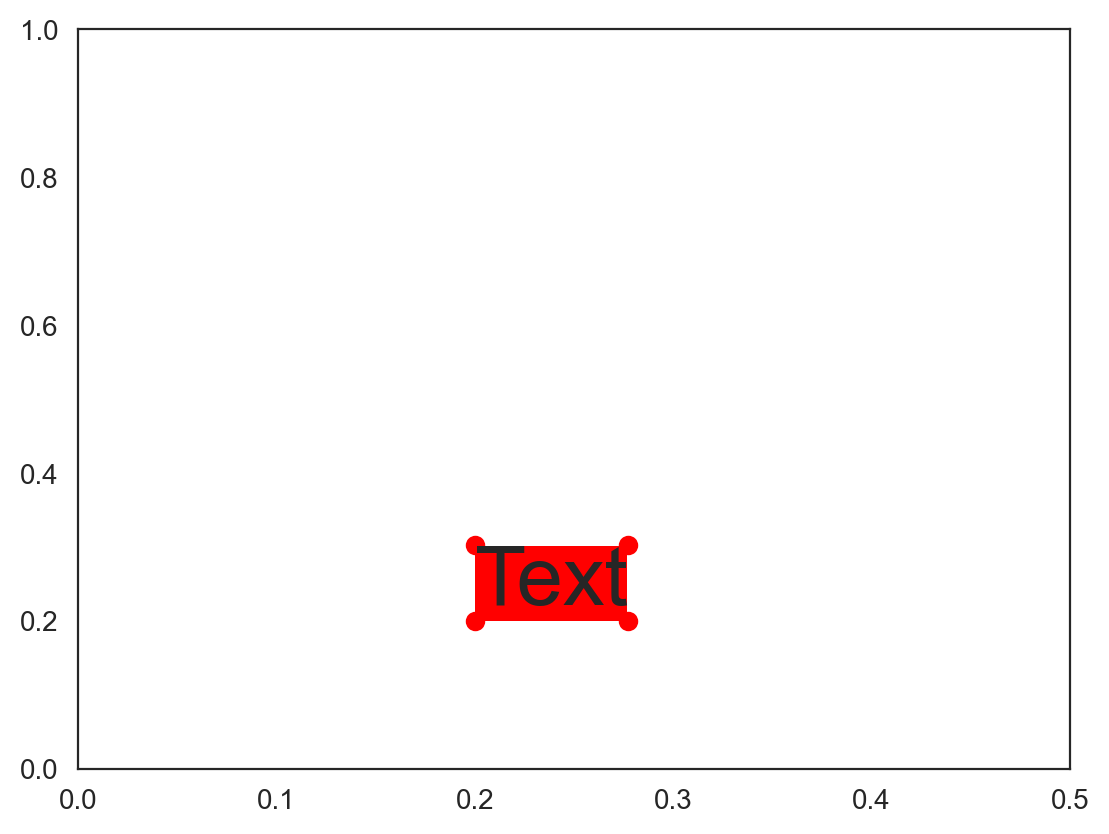

In [559]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)

t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')


from operator import sub
aspect_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

#x0, y0 = coords[0]
# (x0, y0), (x1, y2) = coords
trafo = matplotlib.transforms.Affine2D().rotate_deg_around(x0,y0,45).skew(1, 1.3)#.scale(0.5)

coords = trafo.transform([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
# coords = trafo.transform([(x0, y0), (x1, y1)])
# coords = trafo.transform(coords)
print(coords)

ax.scatter(*coords.T, zorder=10)

disp_ratio = ax.get_data_ratio()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
disp_ratio = bbox.width / bbox.height
print(disp_ratio)



(x0, y0), (x0, y1), (x1, y1), (x1, y0) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*coords.T)


Polygon([Point(x0, y0), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])


#Bbox.count_overlaps

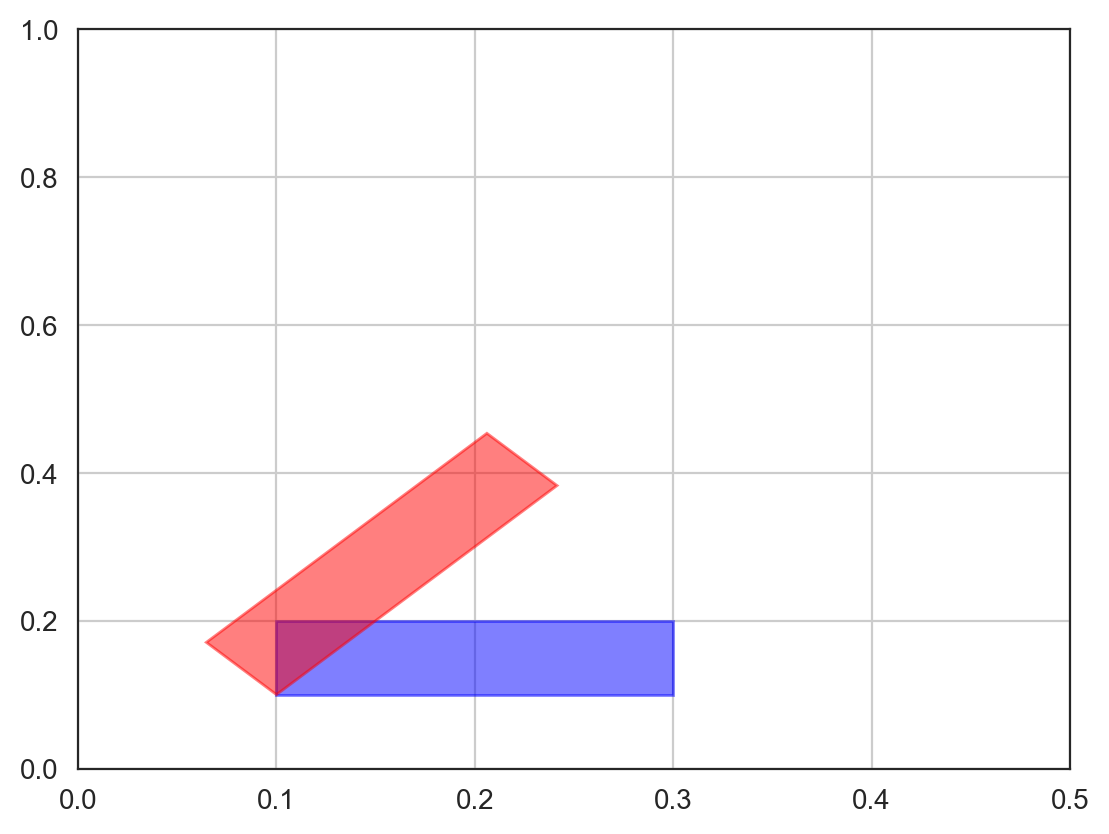

In [560]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig, ax = plt.subplots()

# [[0.25574077 0.46021024]
#  [0.29626452 0.27103643]
#  [0.43571973 0.52198865]
#  [0.39519598 0.71116247]]

# [[0.1        0.1       ]
#  [0.17711694 0.20281385]]
r1 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="blue", alpha=0.5)
r2 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="red", alpha=0.5)


p = 0.1, 0.1 # rotate around this point

x_lim = (0, 0.5)
y_lim = (0, 1)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = y_range / x_range

move_transform = transforms.Affine2D().translate(-p[0], -p[1])
inverse_move_transform = transforms.Affine2D().translate(p[0], p[1])
inverse_scale_transform = transforms.Affine2D().scale(1, 1 / aspect_ratio)
rotate_transform = transforms.Affine2D().rotate_deg(45)
scale_transform = transforms.Affine2D().scale(1, aspect_ratio)

total_transform = move_transform + inverse_scale_transform + rotate_transform + scale_transform + inverse_move_transform + ax.transData

r2.set_transform(total_transform)

ax.add_patch(r1)
ax.add_patch(r2)

# print(ax.transLimits.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(total_transform.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(r2.get_bbox())
# x0, y0, width, height = r2.get_bbox().bounds()
# print(x0, y0)
# coords = [(x0, y0), 
#           (x0 - sqrt(height**2 / 2), y0 + sqrt(height**2 / 2)), 
#           (x0 - sqrt(height**2 / 2) + sqrt(width**2 / 2), y0 + sqrt(height**2 / 2)) +  + sqrt(width**2 / 2), 
#           (x0 + sqrt(width**2 / 2), y0 + sqrt(width**2 / 2))]
# plt.scatter(*zip(*coords))

# coords = ((0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1))
# plt.scatter(*zip(*coords))
# coords = total_transform.transform(coords)
# print(coords)
# plt.scatter(*zip(*coords))

plt.grid(True)
plt.show()

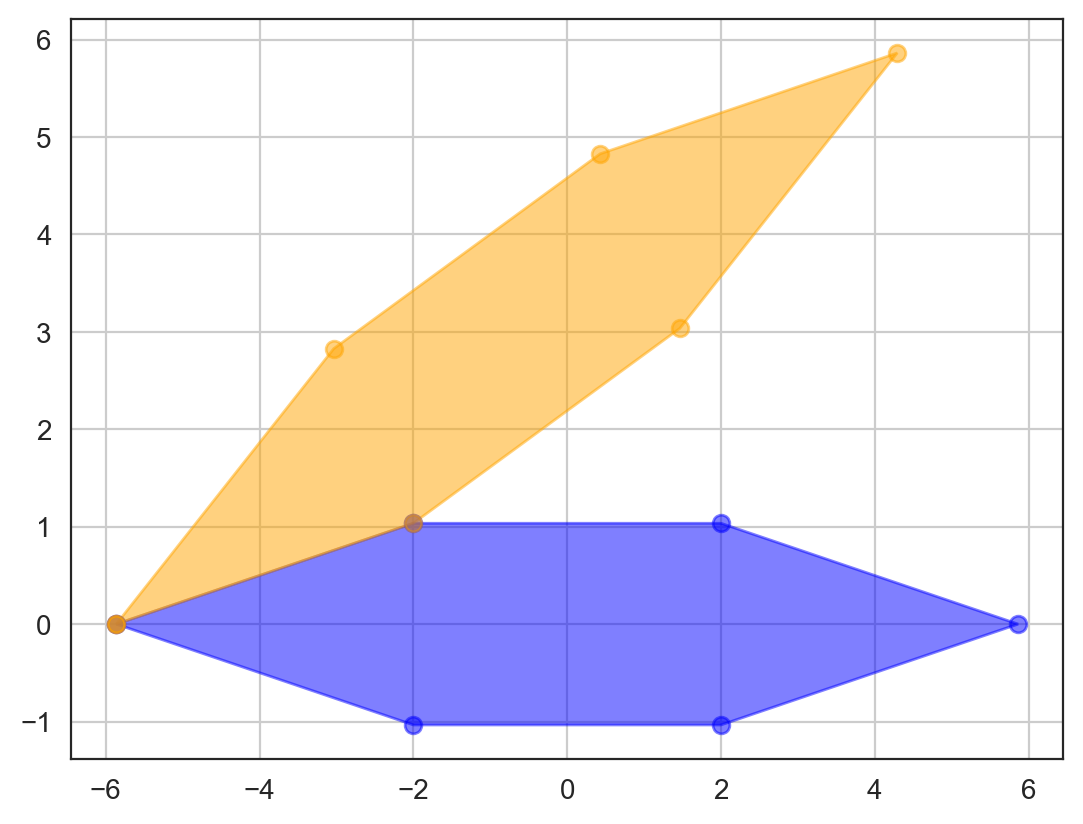

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from math import *

#some helper values
p=4
theta=pi/6
x1 = p*cos(theta/2)
y1 = p*sin(theta/2)
vertices =[(-x1-p/2,0), (-p/2, y1), (p/2, y1), (x1+p/2, 0), (p/2, -y1), (-p/2, -y1)] 
midPoint = [3,4]
endPoint = (-x1-p/2,0)

#set up the plot
fig = plt.figure()
ax = fig.add_subplot(111)

#function to rotate and translate the standard shape to a new position
def plot_polygon(vertices, midPoint, theta, color):
    polygon = patches.Polygon(vertices, color=color, alpha=0.50) 
    r = mpl.transforms.Affine2D().rotate_around(midPoint[0],midPoint[1], theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    tra = r + ax.transData
    # r = mpl.transforms.Affine2D().rotate(theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    # tra = r + t + ax.transData
    polygon.set_transform(tra)
    ax.add_patch(polygon)

    return r.transform(polygon.xy)

p = plot_polygon(vertices, endPoint, 0, "blue")
#plot_polygon(vertices, midPoint, theta, "blue")
p_ = plot_polygon(vertices, endPoint, theta, "orange")

# print(p.get_xy())
# print(p_.get_xy())
# print(p.get_transform().transform(p.xy))
# print(p_.get_transform().transform(p_.xy))
#The correct answer is: tra.transform(poly.xy)


plt.scatter(*zip(*p), color='blue', alpha=0.5)
plt.scatter(*zip(*p_), color='orange', alpha=0.5)

# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

plt.grid(True)

plt.show()

In [596]:
chrom_size = 12e5
ylim = (0, 3)
xlim = (0, chrom_size)
data_height = (ylim[1] - ylim[0])
data_width = (xlim[1] - xlim[0])
aspect = data_height / data_width
aspect
# data_width * aspect
# ylim = ylim * sub(*ylim) / sub(*xlim)
# chrom_size * sub(*ylim) / sub(*xlim)

2.5e-06

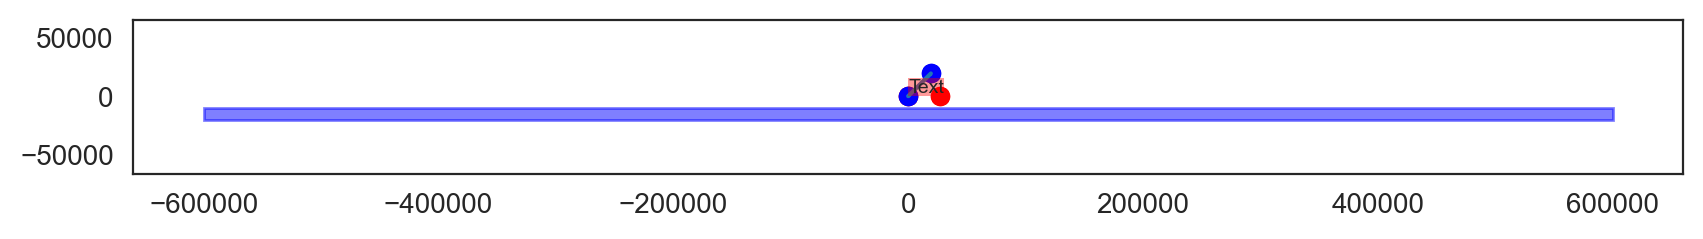

In [586]:
import pandas as pd
import math
from operator import sub
coords = [(0, 0), (0, 1e4), (3e4, 1e4), (3e4, 0)]


chrom_size = 12e5
ylim = np.array([0, 3])
xlim = np.array([0, chrom_size])
ylim = sub()sub(ylim) / sub(xlim) *

# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 1), sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 1), sharex=True)
ax.set_xlim(-6e5, 6e5)
ax.set_ylim(-6e4, 6e4)
ax.axis('equal')

# t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
#                          verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
# box = t.get_bbox_patch()
# fig.canvas.draw()
# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)
# # coords = ax.transData.inverted().transform(box.get_window_extent())
# #coords = ax.transAxes.transform(coords)

# # print(coords)
# # print(ax.transLimits.transform(coords))

t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()

(x0, y0), (x1, y1) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
ax.scatter(*coords.T, c='red')

# ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)

x, y = zip(*coords)
df = pd.DataFrame(dict(x=x, y=y))
dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
df['x'] = dfx
coords = np.array(list(zip(df.x, df.y)))

ax.scatter(*coords.T, c='blue')

ax.plot(*zip(*coords))

# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)

rect = patches.Rectangle((-6e5, -2e4), 12e5, 1e4, color="blue", alpha=0.5)
ax.add_patch(rect) ;

[[0.2        0.2       ]
 [1.97368952 0.30281385]]


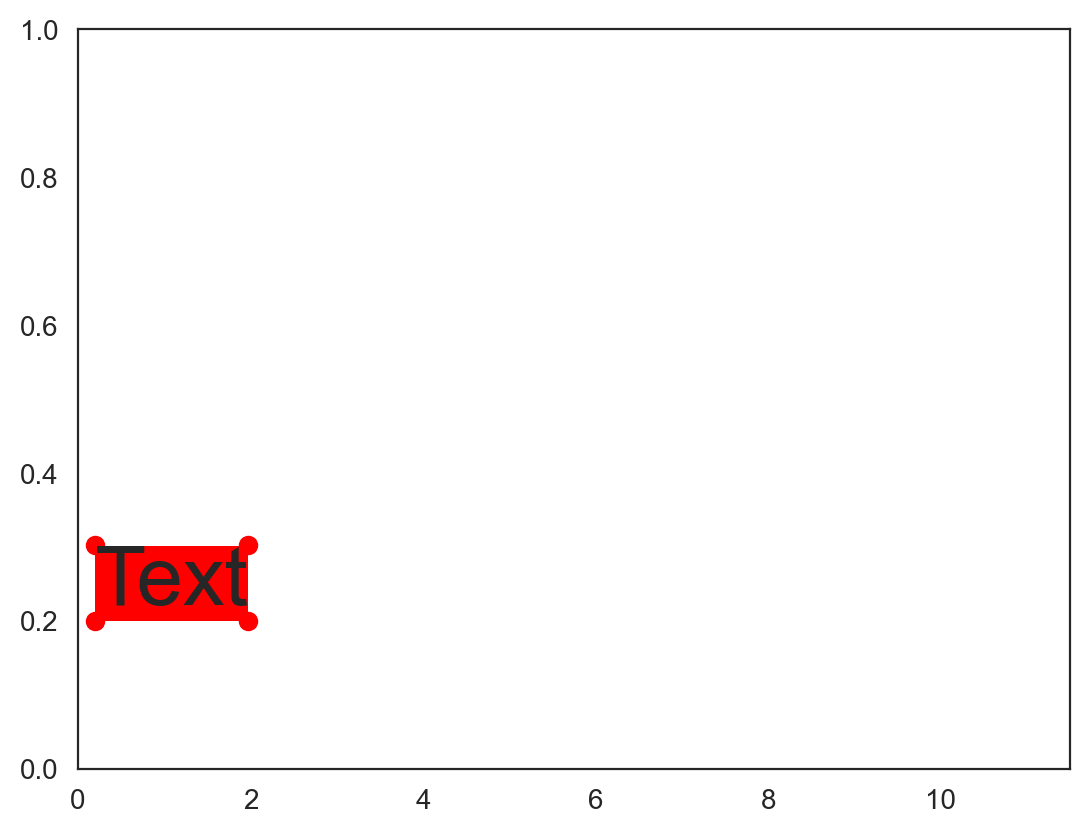

In [566]:
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)
t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))


transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')



[[0.1        0.1       ]
 [0.25716788 0.0862437 ]]
[[0.1        0.23      ]
 [0.25716788 0.2162437 ]]


AttributeError: 'NoneType' object has no attribute 'get_points'

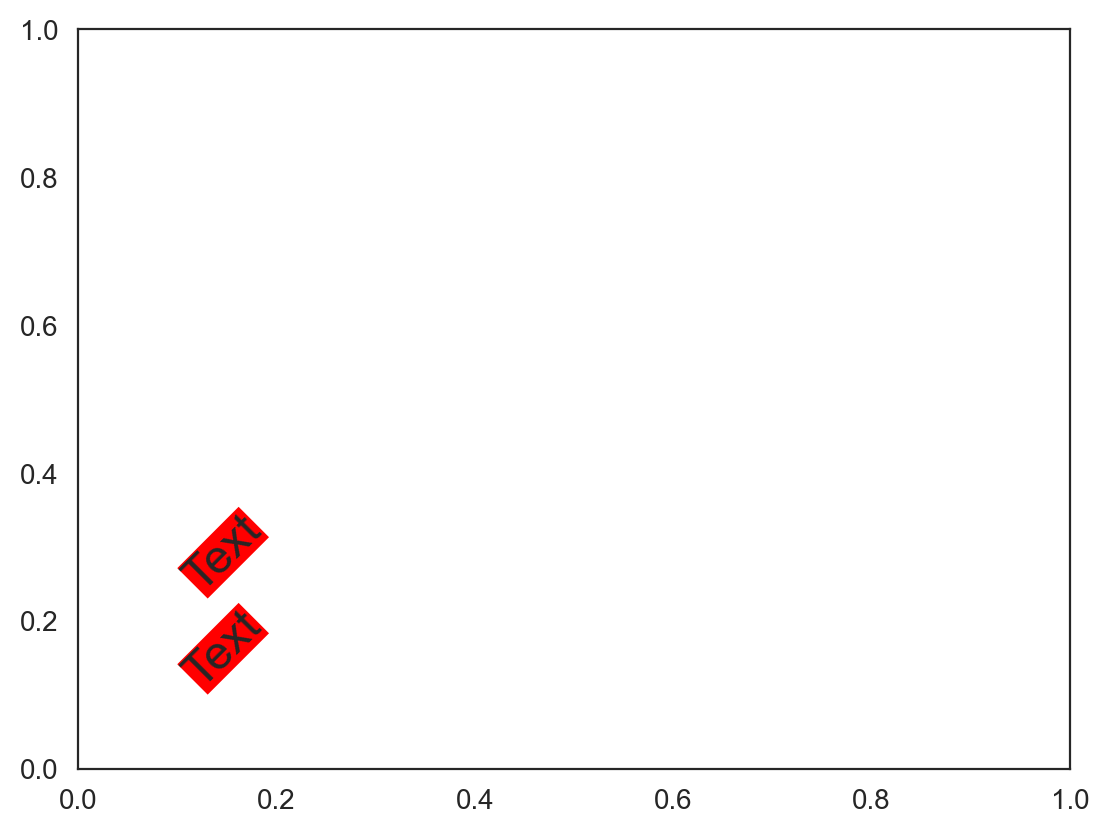

In [391]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()

def get_polygon(t):

    transf = ax.transData.inverted()
    bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    bbt = bb.transformed(transf)
    coords = bbt.get_points()

    x0, y0 = coords[0]
    trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,-)
    print(trafo.transform(coords))

# bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # coords = bb.get_points()
    # print(coords)
    # x0, y0 = coords[0]
    # print(x0, y0)
    # trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,45)

    # coords = bb.get_points()
    # print(coords)
    # print(trafo.transform(coords))

    # transf = ax.transData.inverted()
    # bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # bbt = bb.transformed(transf)
    # # return bbt
    # b = bbt.bounds
    # # print(dir(bbt), bbt.rotated(0.785398).corners())

    # return Polygon([Point(b[0], b[1]), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])
    # # return Polygon([Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin)])

t = ax.text(0.1, 0.1, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
a = get_polygon(t)
#xs, ys = zip(*[(p.x, p.y) for p in a.get_points()])
# print(xs, ys)

t = ax.text(0.1, 0.23, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
#ax.plot(xs,ys) 
b = get_polygon(t)
is_polygons_intersecting(a, b)

#print(Bbox.intersection(a, b))

Bbox(x0=72266463.49999999, y0=2.299999999999999, x1=78844788.63027559, y1=4.219218090860526)
Bbox(x0=38185129.999999985, y0=2.299999999999999, x1=43874492.27483292, y1=3.959864294798294)
Bbox(x0=2916660.500000015, y0=2.299999999999999, x1=8677139.803268358, y1=3.9806125984832725)
Bbox(x0=1428450.5, y0=2.299999999999999, x1=8042334.144493267, y1=4.229592242703012)
Bbox(x0=44533249.000000015, y0=2.299999999999999, x1=52320563.613677576, y1=4.571939253505164)
Bbox(x0=6908011.500000015, y0=2.299999999999999, x1=12632932.289050654, y1=3.9702384466407814)
Bbox(x0=53064702.000000015, y0=2.299999999999999, x1=60531989.985718235, y1=4.478571886922758)
Bbox(x0=119654546.99999999, y0=2.299999999999999, x1=127619654.1847661, y1=4.623810012717609)
Bbox(x0=48684013.500000015, y0=2.299999999999999, x1=53626646.976261124, y1=3.7420071061060156)
Bbox(x0=15840368.500000015, y0=2.299999999999999, x1=22169784.03075163, y1=4.146599027963099)
Bbox(x0=16742475.999999985, y0=2.299999999999999, x1=23107450.044

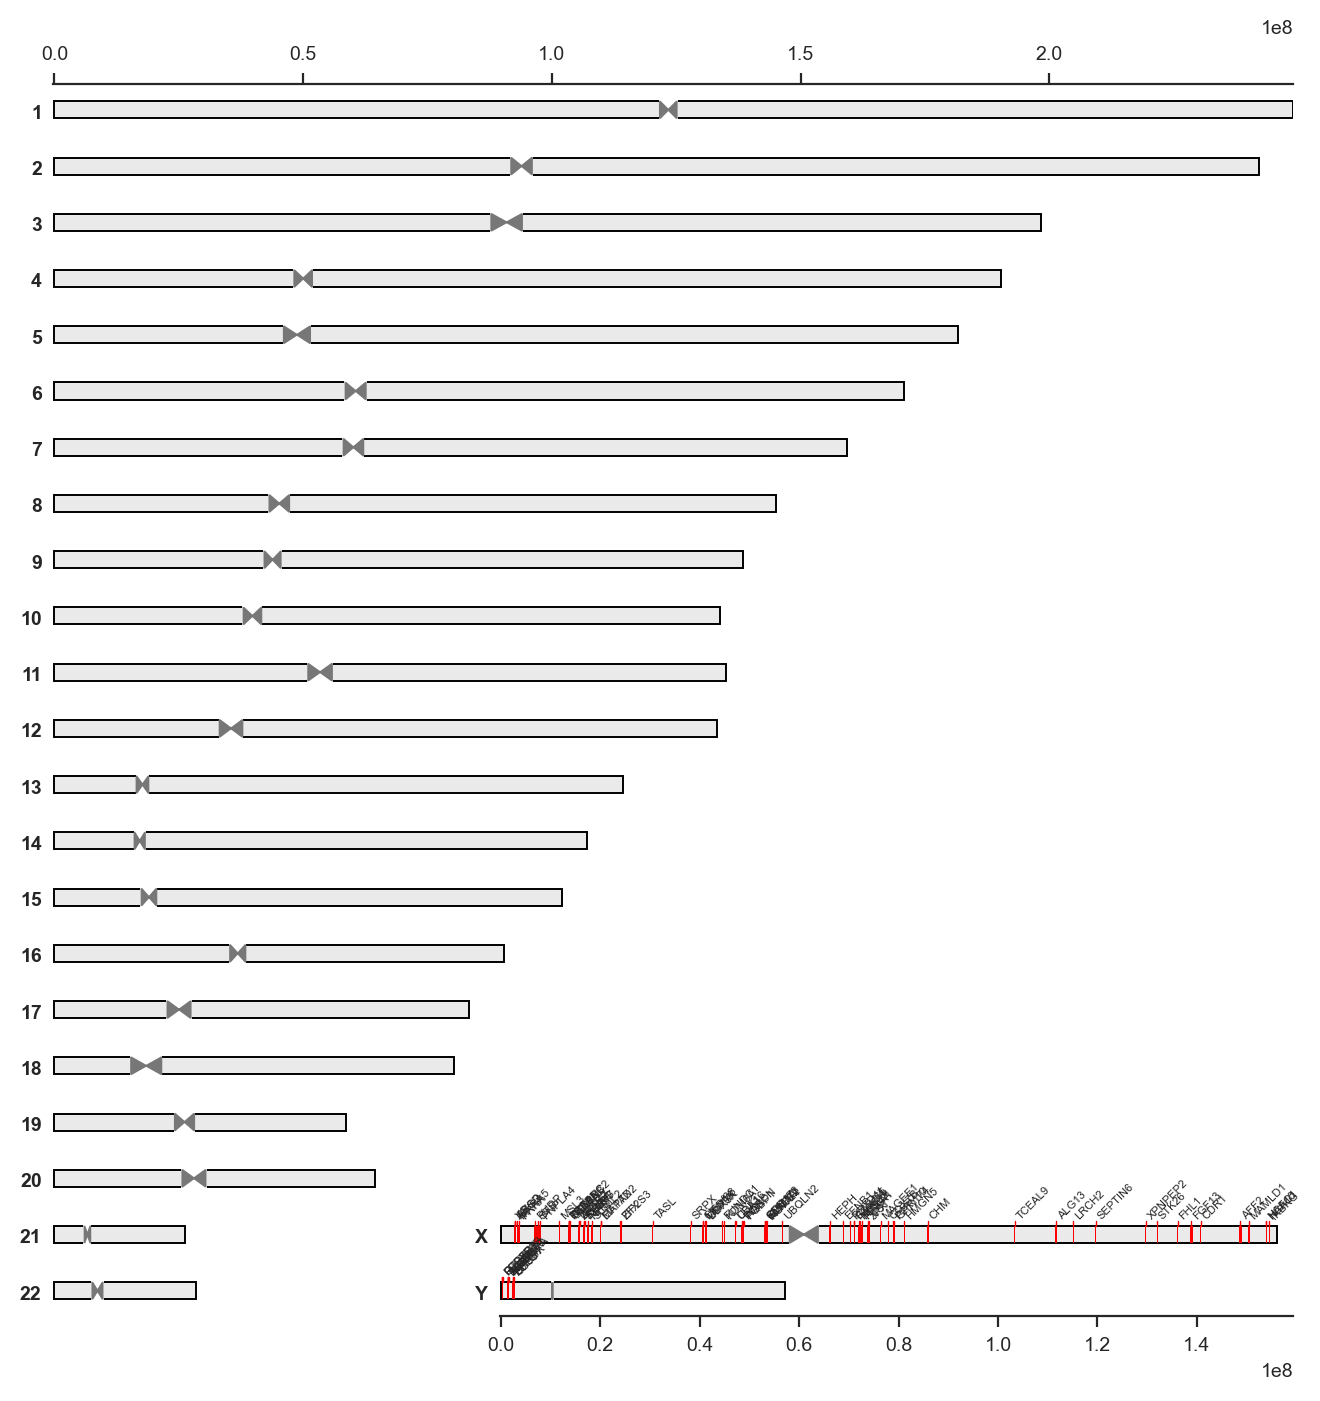

In [24]:
import importlib
import geneinfo
importlib.reload(geneinfo)

gi.chrom_ideogram(annotation, figsize=(8, 8))